**IT1244 - Team 20 - mRNA Classification Project**

## BioPython and SeqIO Pipeline Installation

In [117]:
pip install biopython

In [118]:
pip install SeqIO

## Import Necessary Libraries


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from io import StringIO

## Uploading Given Datasets and Necessary Files from GitHub

- For CNN Implementation, "CNN_best_threshold.txt" and "CNN_final_model.h5" can be found and downloaded from Model & Dataset Folder in our Github.

- For LSTM Implementation, "LSTM_model.h5" can be found and downloaded from Model & Dataset Folder in our Github.

In [120]:
from google.colab import files
uploaded = files.upload()

Saving CNN_best_threshold.txt to CNN_best_threshold.txt
Saving CNN_final_model.h5 to CNN_final_model.h5
Saving LSTM_model.h5 to LSTM_model.h5
Saving test.csv to test.csv
Saving training.fa to training.fa
Saving training_class.csv to training_class.csv


##Fasta-to-CSV convertion

In [121]:
def read_fast_file(file_path: str):
    records = list(SeqIO.parse(file_path, "fasta"))
    IDs = [rec.id for rec in records]
    sequences = [str(rec.seq).upper() for rec in records]
    descriptions = [rec.description for rec in records]
    return IDs, sequences, descriptions

In [122]:
IDs, sequences, description = read_fast_file("training.fa")

In [123]:
print(f"Total sequences: {len(sequences)}")
print(f"First ID: {IDs[0]}")
print(f"First description: {description[0]}")
print(f"First 100 bases: {sequences[0][:100]}")

Total sequences: 22867
First ID: ENSDART00000138379
First description: ENSDART00000138379
First 100 bases: TCAAANGGAAAATAATATGTCAGYTGTGATTTTTACTCGANTTAATACGATCACGACTGACTTTGTCDACGAAAATMATCAGAGTGACACGATGGCTTCT


In [124]:
def fasta_to_csv(fasta_file: str, csv_file: str) -> pd.DataFrame:
  IDs, sequences, _ = read_fast_file(fasta_file)

  df = pd.DataFrame({
      "name": IDs,
      "Sequence": [seq.upper() for seq in sequences],
  })
  df.to_csv(csv_file, index=False)
  return df

In [125]:
df = fasta_to_csv("training.fa", "training.csv")

In [126]:
print(df.head())

                 name                                           Sequence
0  ENSDART00000138379  TCAAANGGAAAATAATATGTCAGYTGTGATTTTTACTCGANTTAAT...
1  ENSDART00000075994  ATGTCTCTTTTTGAAATAAAAGACCTGNTTNGAGAAGGAAGCTATG...
2  ENSDART00000153938  AGACCAGTGGTTTAGCAGCAACAGCTTTCGAGCGACGGAAACATGC...
3  ENSDART00000152541  CGATGGGTCCGACCAAGATGGCGCTCTAACAACAAGCAGATCGATG...
4  ENSDART00000139170  TCGGACTTCTCATATGTTTTCGACTCTTCGAAGAACTAAACATTAA...


In [127]:
def add_labels(training_df, training_label_df, file_saved_path):
  merged_df = pd.merge(training_df, training_label_df, on = "name", how = "inner")
  merged_df.to_csv(file_saved_path)
  return merged_df

In [128]:
training_df = fasta_to_csv("training.fa", "training_no_class.csv")
training_label_df = pd.read_csv("training_class.csv")
file_saved_path = "training.csv"

df = add_labels(training_df, training_label_df, file_saved_path)


## Understanding Given Datasets




In [129]:
## null data check
print(df.head())
print(df.info())

                 name                                           Sequence  \
0  ENSDART00000138379  TCAAANGGAAAATAATATGTCAGYTGTGATTTTTACTCGANTTAAT...   
1  ENSDART00000075994  ATGTCTCTTTTTGAAATAAAAGACCTGNTTNGAGAAGGAAGCTATG...   
2  ENSDART00000153938  AGACCAGTGGTTTAGCAGCAACAGCTTTCGAGCGACGGAAACATGC...   
3  ENSDART00000152541  CGATGGGTCCGACCAAGATGGCGCTCTAACAACAAGCAGATCGATG...   
4  ENSDART00000139170  TCGGACTTCTCATATGTTTTCGACTCTTCGAAGAACTAAACATTAA...   

   class  
0      1  
1      1  
2      1  
3      1  
4      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 14285
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      14286 non-null  object
 1   Sequence  14286 non-null  object
 2   class     14286 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 335.0+ KB
None


There are no null-data present in the training dataset.

In [130]:
## duplicates check
print(df['name'].duplicated().sum())

0


There are no duplicates present in the training dataset.

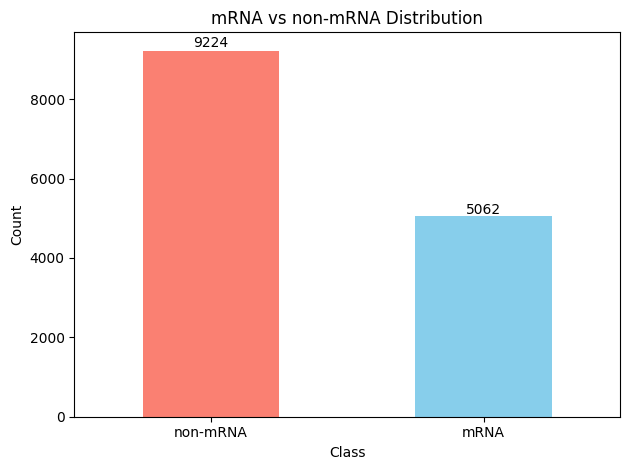

In [131]:
# mRNA vs. non-mRNA distribution diagram
label_map = {0: 'non-mRNA', 1: 'mRNA'}
ax = df['class'].map(label_map).value_counts().plot(
    kind='bar',
    title='mRNA vs non-mRNA Distribution',
    color=['salmon', 'skyblue']
)

for i, v in enumerate(df['class'].value_counts()):
    ax.text(i, v * 1.01, str(v), ha='center', fontweight='light')

ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.show()

There are 9244 non-mRNA sequences and 5062 mRNA sequences. Thus, there are an imbalance within the dataset.

##Solving Ambiguity using Positional Embeddings

- While all sequences in the test dataset consists of only 4 types of letters (i.e., "A" for adenine, "U" for urasil, "G" for guanine, "C" for cytosine), that is not the case in the training dataset due to experimental errors. When the type of nucleotide could not be distinguished accurately. (e.g., It could be a adenine or guanine, it's represented as a different letter "R").

- Thus, we propose this solution to the ambiguity issue with the training dataset.

In [132]:
import random
df = pd.read_csv("training.csv")

In [133]:
print(df.head())
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

   Unnamed: 0                name  \
0           0  ENSDART00000138379   
1           1  ENSDART00000075994   
2           2  ENSDART00000153938   
3           3  ENSDART00000152541   
4           4  ENSDART00000139170   

                                            Sequence  class  
0  TCAAANGGAAAATAATATGTCAGYTGTGATTTTTACTCGANTTAAT...      1  
1  ATGTCTCTTTTTGAAATAAAAGACCTGNTTNGAGAAGGAAGCTATG...      1  
2  AGACCAGTGGTTTAGCAGCAACAGCTTTCGAGCGACGGAAACATGC...      1  
3  CGATGGGTCCGACCAAGATGGCGCTCTAACAACAAGCAGATCGATG...      1  
4  TCGGACTTCTCATATGTTTTCGACTCTTCGAAGAACTAAACATTAA...      1  

Dataset shape: (14286, 4)
Columns: ['Unnamed: 0', 'name', 'Sequence', 'class']


As shown above, some sequences contain characters other than the standard nucleotides "A", "T", "G", and "C". We will use the following mapping to handle these ambiguous nucleotides.

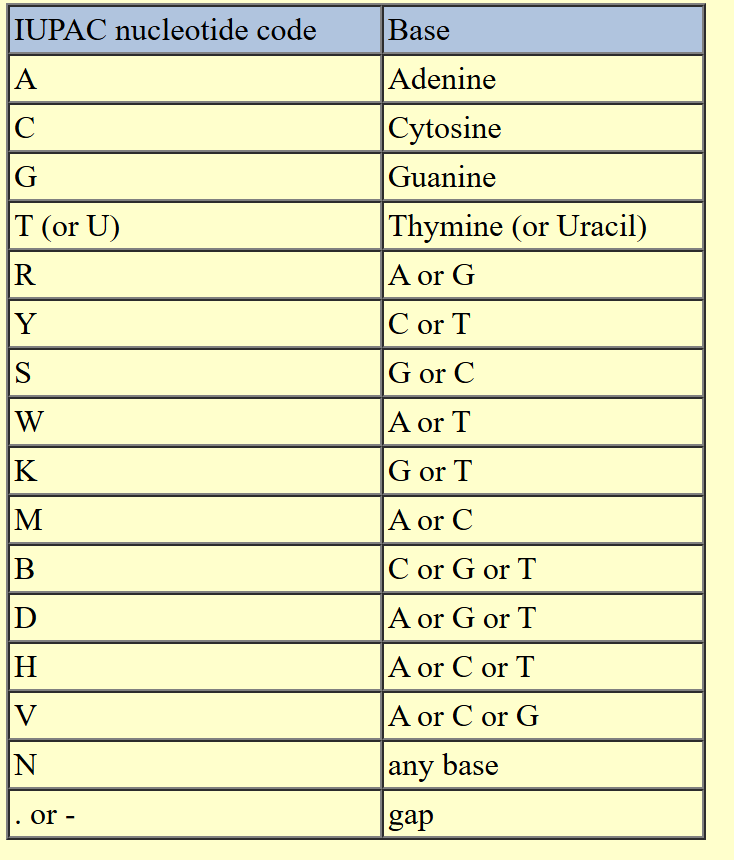





In [134]:
import random

IUPAC_MAP = {
    "A": ["A"], "C": ["C"], "G": ["G"], "T": ["T"],
    "R": ["A", "G"], "Y": ["C", "T"], "S": ["G", "C"], "W": ["A", "T"],
    "K": ["G", "T"], "M": ["A", "C"], "B": ["C", "G", "T"],
    "D": ["A", "G", "T"], "H": ["A", "C", "T"], "V": ["A", "C", "G"],
    "N": ["A", "C", "G", "T"]
}


## In this case, we will randomly resolve each ambiguous character by selecting
## one possible base. For example, the sequence "ARCG" can yield two possible
## outcomes: "AACG" or "AGCG". We will randomly choose one of them and replace
## it with the original sequence. Depending on the number of possible outcomes
## for certains IUPAC letters, the chances of choosing are ensured to be equal

def generate_sequence(seq, seed=None):
    new_sequence = ""
    if seed is not None:
      random.seed(seed)
    for char in seq:
        new_sequence += random.choice(IUPAC_MAP.get(char, [char]))
    return new_sequence

In [135]:
# create a copy of the original sequence for ambiguity feature analysis
df_original = df.copy()

In [136]:
# applying positional embeddings to the sequences using above mapping
df["Sequence"] = df["Sequence"].apply(generate_sequence)

IUPAC_AMBIG = set("RYSWKMBDHVN")
all_bases = ''.join(df["Sequence"].astype(str).tolist())
remaining = [b for b in all_bases if b in IUPAC_AMBIG]

print(f"Number of ambiguous bases left: {len(remaining)}")

Number of ambiguous bases left: 0


There are no ambiguous bases left in the training dataset. We are now moving onto Exploratory Data Analysis (EDA)

#Exploratory Data Analysis (EDA)



## Length Distribution

- The sequence length feature captures the overall transcript size of each RNA molecule.

- Biologically, mRNAs are protein-coding transcripts that contain long open reading frames (ORFs), untranslated regions (UTRs), and various regulatory elements.

- As a result, they tend to be substantially longer than non-coding RNAs, which are typically shorter and structurally constrained.

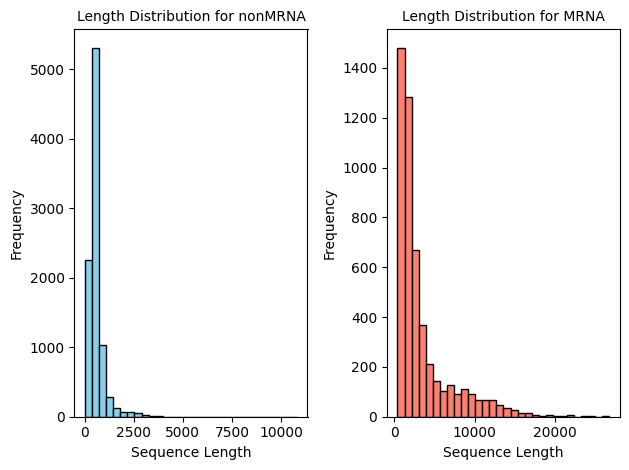

In [137]:
# visualise length distribution via histograms

seq_len_nonMRNA = [len(seq) for seq in df[df['class'] == 0]['Sequence']]
seq_len_MRNA = [len(seq) for seq in df[df['class'] == 1]['Sequence']]

plt.subplot(1, 2, 1)
plt.hist(seq_len_nonMRNA, bins=30, color='skyblue', edgecolor='black')
plt.title('Length Distribution for nonMRNA', fontsize = 10)
plt.xlabel('Sequence Length', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)

plt.subplot(1, 2, 2)
plt.hist(seq_len_MRNA, bins=30, color='salmon', edgecolor='black')
plt.title('Length Distribution for MRNA', fontsize = 10)
plt.xlabel('Sequence Length', fontsize = 10)
plt.ylabel('Frequency', fontsize = 10)

plt.tight_layout()
plt.show()

In [138]:
df["length"] = df["Sequence"].str.len()

# Summary statistics per class
length_stats = (
    df.groupby("class")["length"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .rename(index={0: "non-mRNA", 1: "mRNA"})
)

print("\nLength distribution summary (non-mRNA vs mRNA):")
print(length_stats)


Length distribution summary (non-mRNA vs mRNA):
          count         mean  median          std  min    max
class                                                        
non-mRNA   9224   596.429098   515.0   428.304240   21  10809
mRNA       5062  3413.291584  1941.5  3639.162895  393  26831


##K-mer distribution

### 4-mers


- Tetranucleotide (4-mer) can capture overlapping codon contexts and local motifs linked to translational coupling, reading-frame bias, or secondary-structure elements (Baha & Abdulkadir, 2021).

- Certain 4-mer combinations occur preferentially in mRNAs due to selection on codon pairs and translational efficiency, whereas non-coding RNAs show more uniform usage (Deng, Jia, & Yi, 2024).

- Consequently, 4-mers complement 3-mers by encoding finer contextual information while preserving interpretability.

In [139]:
from collections import Counter

DNA = {'A','T','C','G'}

def kmer_generation(sequence, k=4):
    if not isinstance(sequence, str) or k <= 0:
        return []
    s = sequence.upper()
    sequence_length = len(s)
    if sequence_length < k:
        return []
    kmers = []
    for i in range(sequence_length - k + 1):
        kmer = s[i:i+k]
        if set(kmer) <= DNA:
            kmers.append(kmer)
    return kmers

def count_kmers(sequence, top_kmers, k=4):
    kmer_counts = Counter(kmer_generation(sequence, k))
    counts_for_top = {}
    for km in top_kmers:
        counts_for_top[km] = kmer_counts.get(km, 0)
    return counts_for_top

In [140]:
from collections import Counter

k = 4

data_4mer_nonMRNA = Counter()
data_4mer_MRNA = Counter()

# Count 4-mers in non-mRNA sequences
for seq in df.loc[df['class'] == 0, 'Sequence']:
    _4mers = kmer_generation(seq, k)
    data_4mer_nonMRNA.update(_4mers)

# Count 4-mers in mRNA sequences
for seq in df.loc[df['class'] == 1, 'Sequence']:
    _4mers = kmer_generation(seq, k)
    data_4mer_MRNA.update(_4mers)

In [141]:
print(f"Unique 4-mers in non-mRNA: {len(data_4mer_nonMRNA)}")
print(f"Unique 4-mers in mRNA: {len(data_4mer_MRNA)}")

Unique 4-mers in non-mRNA: 256
Unique 4-mers in mRNA: 256


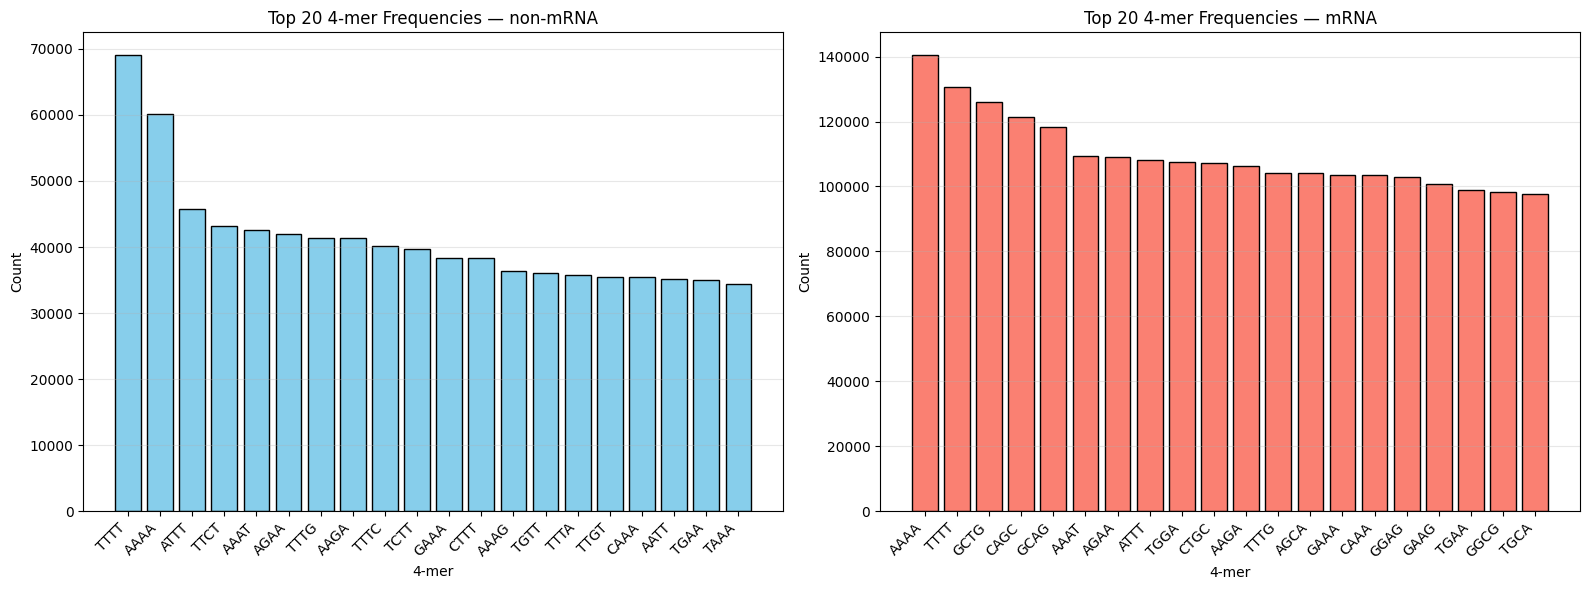

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# --- non-mRNA plot ---
top20_non = data_4mer_nonMRNA.most_common(20)
kmers_non, counts_non = zip(*top20_non)

plt.subplot(1, 2, 1)
plt.bar(kmers_non, counts_non, edgecolor='black', color='skyblue')
plt.title('Top 20 4-mer Frequencies — non-mRNA', fontsize=12)
plt.xlabel('4-mer', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# --- mRNA plot ---
top20_mRNA = data_4mer_MRNA.most_common(20)
kmers_mRNA, counts_mRNA = zip(*top20_mRNA)

plt.subplot(1, 2, 2)
plt.bar(kmers_mRNA, counts_mRNA, edgecolor='black', color='salmon')
plt.title('Top 20 4-mer Frequencies — mRNA', fontsize=12)
plt.xlabel('4-mer', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 3-mers

- Trinucleotide (3-mer) frequencies were extracted to capture codon-usage patterns of mRNAs. Each 3-mer corresponds to a codon, the basic unit of translation, so mRNA sequences display triplet periodicity and non-uniform codon distributions (Wan et al., 2019).

- In contrast, non-coding RNAs lack such codon structure, yielding more random or uniform 3-mer profiles. Modeling 3-mer composition therefore enables the classifier to discriminate structured, protein-coding regions from non-coding transcripts.

- 3-mers provide a biologically meaningful and computationally efficient representation, capturing codon-level regularities without excessive feature dimensionality.

In [143]:
from collections import Counter

k = 3

data_3mer_nonMRNA = Counter()
data_3mer_MRNA = Counter()

# Count 3-mers in non-mRNA sequences
for seq in df.loc[df['class'] == 0, 'Sequence']:
    _3mers = kmer_generation(seq, k)
    data_3mer_nonMRNA.update(_3mers)

# Count 3-mers in mRNA sequences
for seq in df.loc[df['class'] == 1, 'Sequence']:
    _3mers = kmer_generation(seq, k)
    data_3mer_MRNA.update(_3mers)

In [144]:
print(f"Unique 3-mers in non-mRNA: {len(data_3mer_nonMRNA)}")
print(f"Unique 3-mers in mRNA: {len(data_3mer_MRNA)}")

Unique 3-mers in non-mRNA: 64
Unique 3-mers in mRNA: 64


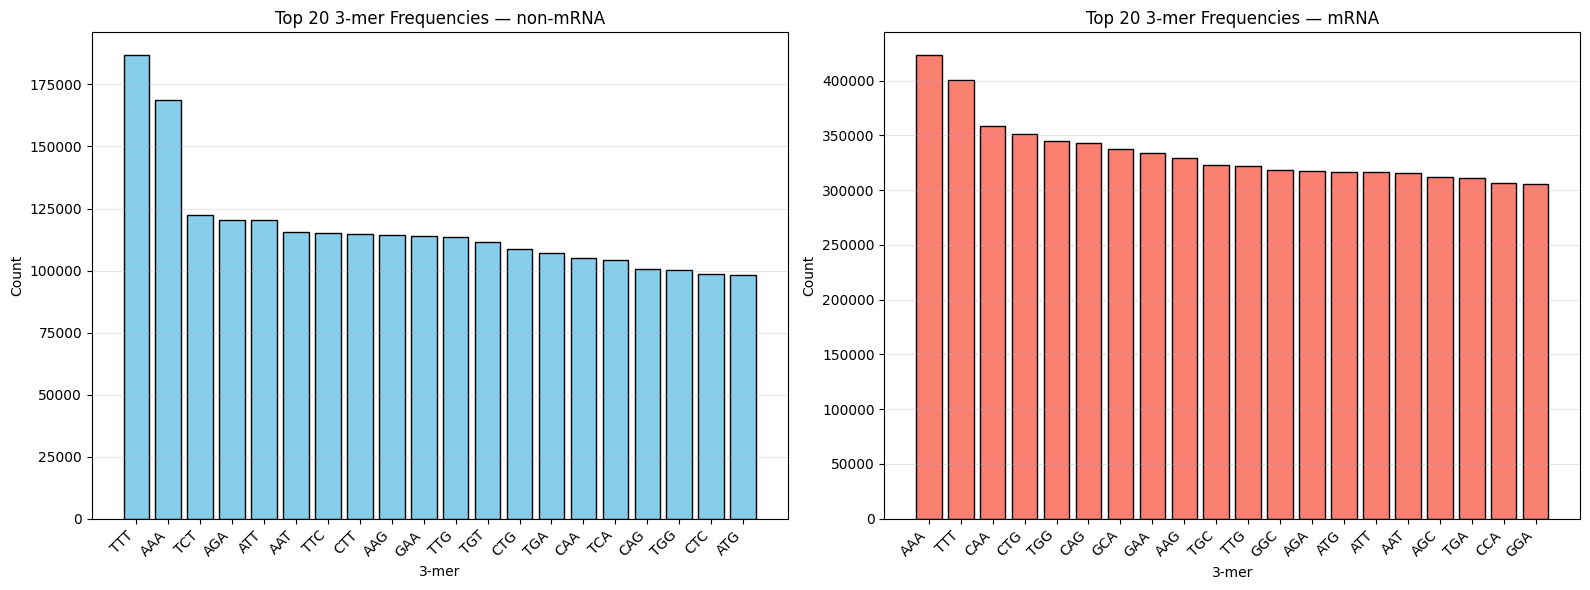

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

# --- non-mRNA plot ---
top20_non = data_3mer_nonMRNA.most_common(20)
kmers_non, counts_non = zip(*top20_non)

plt.subplot(1, 2, 1)
plt.bar(kmers_non, counts_non, edgecolor='black', color='skyblue')
plt.title('Top 20 3-mer Frequencies — non-mRNA', fontsize=12)
plt.xlabel('3-mer', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# --- mRNA plot ---
top20_mRNA = data_3mer_MRNA.most_common(20)
kmers_mRNA, counts_mRNA = zip(*top20_mRNA)

plt.subplot(1, 2, 2)
plt.bar(kmers_mRNA, counts_mRNA, edgecolor='black', color='salmon')
plt.title('Top 20 3-mer Frequencies — mRNA', fontsize=12)
plt.xlabel('3-mer', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

##Ambiguity Distribution






Ambiguity-related features were engineered to quantify the extent of uncertain or low-quality bases (IUPAC ambiguity codes beyond A/C/G/T) present in each sequence. Such ambiguous nucleotides often arise from low-confidence sequencing reads or incomplete transcript assemblies.

In the training dataset, their presence can help distinguish clean mRNAs, which are typically well-curated and high-quality, from non-coding or uncertain transcripts, which tend to contain more ambiguous bases.

Even when the biological meaning is limited, ambiguity features serve as a proxy for sequence reliability. A low ambiguity rate suggests a high-confidence, well-defined transcript (more likely to be mRNA), whereas a high ambiguity rate indicates sequencing noise or unverified regions (more likely to be non-mRNA).

In Random Forest (RF) or Logistic Regression (LR), these features act as implicit data-confidence indicators, enabling the model to down-weight unreliable samples. RF in particular can learn non-linear relationships such as “if ambig_rate > 0.1 → non-mRNA.”

The following features were extracted:

***ambig_rate***: fraction of ambiguous bases over total sequence length - to measure how “uncertain”/”noisy” the sequence is

***ambig_count***: total number of ambiguous bases - to measure the magnitude of ambiguity

***ambig_max_run***: longest contiguous run of ambiguous bases - to capture localized sequencing uncertainty regions

***has_ambig***: binary indicator (1: has ambiguity, 0: clean) - to indicate whether the sequence contains any ambiguous base

***length_ATCG***: number of standard bases - to act as a proxy for clean length


In [146]:
from collections import Counter

def ambiguity_features(sequence: str):

    s = sequence.upper()
    n = len(s)
    ambigs = [b for b in s if b in IUPAC_AMBIG]

    ambig_count = len(ambigs)

    run = 0
    best = 0
    for b in s:
        if b in IUPAC_AMBIG:
            run += 1
            if run > best:
                best = run
        else:
            run = 0

    out = {
        'ambig_rate': (ambig_count / n) if n else 0.0,
        'ambig_count': ambig_count,
        'ambig_max_run': best,
        'has_ambig': int(ambig_count > 0),
        'length_ATCG': sum(1 for b in s if b in DNA),
    }
    return out

In [147]:
ambig_feat_series = df_original["Sequence"].apply(ambiguity_features)
ambig_feat_df = pd.DataFrame(list(ambig_feat_series))

In [148]:
print(ambig_feat_df.head())

   ambig_rate  ambig_count  ambig_max_run  has_ambig  length_ATCG
0    0.045968          118              2          1         2449
1    0.042929           34              2          1          758
2    0.000000            0              0          0         2122
3    0.000000            0              0          0         3957
4    0.000000            0              0          0         1002


In [149]:
print(df.head())

   Unnamed: 0                name  \
0           0  ENSDART00000138379   
1           1  ENSDART00000075994   
2           2  ENSDART00000153938   
3           3  ENSDART00000152541   
4           4  ENSDART00000139170   

                                            Sequence  class  length  
0  TCAAATGGAAAATAATATGTCAGCTGTGATTTTTACTCGAATTAAT...      1    2567  
1  ATGTCTCTTTTTGAAATAAAAGACCTGCTTCGAGAAGGAAGCTATG...      1     792  
2  AGACCAGTGGTTTAGCAGCAACAGCTTTCGAGCGACGGAAACATGC...      1    2122  
3  CGATGGGTCCGACCAAGATGGCGCTCTAACAACAAGCAGATCGATG...      1    3957  
4  TCGGACTTCTCATATGTTTTCGACTCTTCGAAGAACTAAACATTAA...      1    1002  


In [150]:
df_ambig = pd.concat(
    [df.reset_index(drop=True),
     ambig_feat_df.reset_index(drop=True)],
    axis=1
)

print(df_ambig.head())
print(df_ambig.shape)

   Unnamed: 0                name  \
0           0  ENSDART00000138379   
1           1  ENSDART00000075994   
2           2  ENSDART00000153938   
3           3  ENSDART00000152541   
4           4  ENSDART00000139170   

                                            Sequence  class  length  \
0  TCAAATGGAAAATAATATGTCAGCTGTGATTTTTACTCGAATTAAT...      1    2567   
1  ATGTCTCTTTTTGAAATAAAAGACCTGCTTCGAGAAGGAAGCTATG...      1     792   
2  AGACCAGTGGTTTAGCAGCAACAGCTTTCGAGCGACGGAAACATGC...      1    2122   
3  CGATGGGTCCGACCAAGATGGCGCTCTAACAACAAGCAGATCGATG...      1    3957   
4  TCGGACTTCTCATATGTTTTCGACTCTTCGAAGAACTAAACATTAA...      1    1002   

   ambig_rate  ambig_count  ambig_max_run  has_ambig  length_ATCG  
0    0.045968          118              2          1         2449  
1    0.042929           34              2          1          758  
2    0.000000            0              0          0         2122  
3    0.000000            0              0          0         3957  
4    0.000

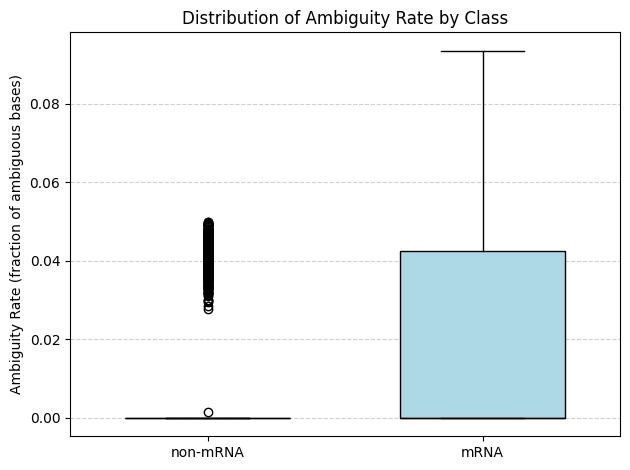

In [151]:
ambig_rate_non = df_ambig[df_ambig['class'] == 0]['ambig_rate']
ambig_rate_mrna = df_ambig[df_ambig['class'] == 1]['ambig_rate']

plt.boxplot([ambig_rate_non, ambig_rate_mrna],
            tick_labels=['non-mRNA', 'mRNA'],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='black'),
            widths=0.6)

plt.title('Distribution of Ambiguity Rate by Class', fontsize=12)
plt.ylabel('Ambiguity Rate (fraction of ambiguous bases)', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

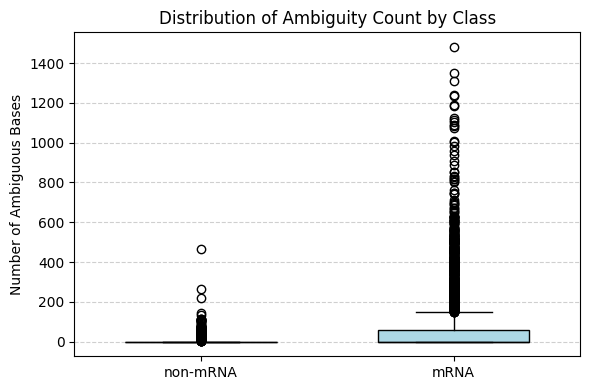

In [152]:
ambig_count_non = df_ambig[df_ambig['class'] == 0]['ambig_count']
ambig_count_mrna = df_ambig[df_ambig['class'] == 1]['ambig_count']

plt.figure(figsize=(6,4))
plt.boxplot([ambig_count_non, ambig_count_mrna],
            tick_labels=['non-mRNA', 'mRNA'],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='black'),
            widths=0.6)

plt.title('Distribution of Ambiguity Count by Class', fontsize=12)
plt.ylabel('Number of Ambiguous Bases', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

class
0     831
1    1836
Name: has_ambig, dtype: int64


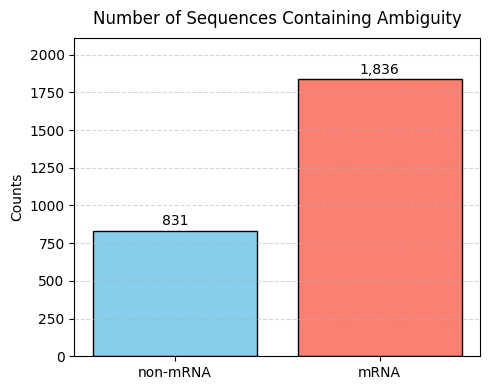

In [153]:
ambig_presence = df_ambig.groupby('class')['has_ambig'].sum()
print(ambig_presence)

plt.figure(figsize=(5,4))
bars = plt.bar(
    ['non-mRNA', 'mRNA'],
    ambig_presence,
    color=['skyblue', 'salmon'],
    edgecolor='black'
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + (0.01 * max(ambig_presence)),
        f"{int(height):,}",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='medium',
        color='black'
    )

plt.title('Number of Sequences Containing Ambiguity', fontsize=12, pad=10)
plt.ylabel('Counts', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, max(ambig_presence) * 1.15)
plt.tight_layout()
plt.show()

##Physiochemical Features

- Physicochemical features summarize base composition and strand skews that correlate with coding potential. The mononucleotide fractions (%A, %T, %C, %G) and GC content capture compositional patterns that shape RNA structure; mRNAs typically exhibit moderate GC content, whereas many non-mRNAs favor compositions that stabilize helical stems (Courel et al., 2019).

- The purine-to-pyrimidine ratio is also informative: mRNAs are often slightly purine-loaded (A/G-rich) compared with non-mRNAs, which can facilitate translation (Paz et al., 2004).

In [154]:
def physicochemical_features(sequence):
    s = ''.join([b for b in sequence.upper() if b in {'A', 'T', 'C', 'G'}])
    n = len(s)
    if n == 0:
        return {'%A': 0, '%T': 0, '%C': 0, '%G': 0, 'GC_content': 0, 'purine_pyrimidine_ratio': 0}

    counts = Counter(s)
    A, T, C, G = counts.get('A', 0), counts.get('T', 0), counts.get('C', 0), counts.get('G', 0)

    composition = {
        '%A': A / n,
        '%T': T / n,
        '%C': C / n,
        '%G': G / n,
        'GC_content': (G + C) / n
    }

    purine = A + G
    pyrimidine = C + T
    composition['purine_pyrimidine_ratio'] = purine / pyrimidine if pyrimidine != 0 else 0

    return composition

In [155]:
phys_features_list = [physicochemical_features(seq) for seq in df['Sequence']]
features_df = pd.DataFrame(phys_features_list)
features_df['class'] = df['class']

In [156]:
print(features_df.describe())
print(features_df.groupby('class')[['GC_content', 'purine_pyrimidine_ratio']].mean())

                 %A            %T            %C            %G    GC_content  \
count  14286.000000  14286.000000  14286.000000  14286.000000  14286.000000   
mean       0.272451      0.274083      0.224491      0.228976      0.453466   
std        0.051376      0.060882      0.053276      0.051731      0.089323   
min        0.011696      0.000000      0.000000      0.007310      0.081818   
25%        0.241919      0.231638      0.188249      0.195374      0.391608   
50%        0.275096      0.274622      0.217092      0.223569      0.438064   
75%        0.305133      0.315789      0.255550      0.255924      0.509278   
max        0.805556      0.713450      0.569892      0.576132      0.891667   

       purine_pyrimidine_ratio         class  
count             14286.000000  14286.000000  
mean                  1.034843      0.354333  
std                   1.069829      0.478327  
min                   0.000000      0.000000  
25%                   0.905069      0.000000  
50%   

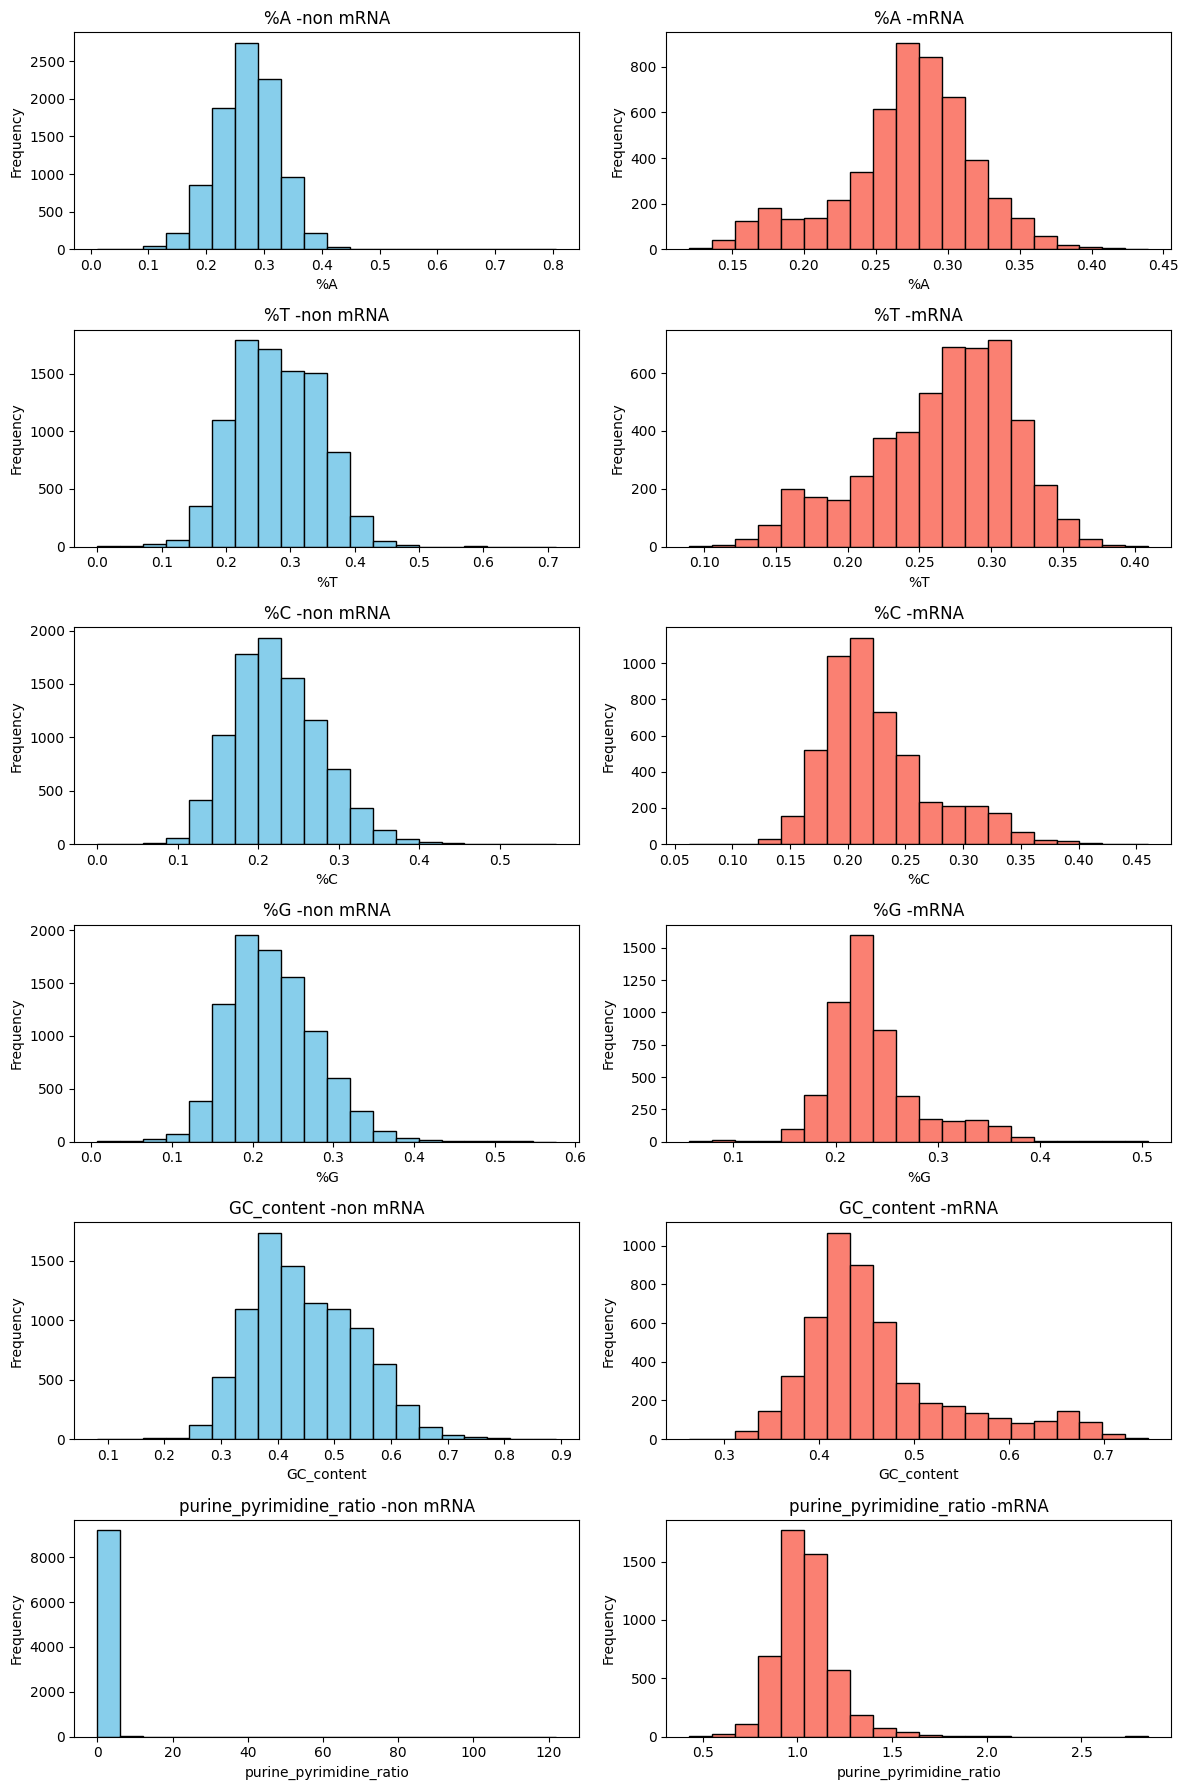

In [157]:
import matplotlib.pyplot as plt

features = features_df.columns.drop('class')  # exclude class column

plt.figure(figsize=(12, 6 * 3))

for i, feature in enumerate(features):
    #plot for non-mRNA of feature
    plt.subplot(6, 2, 2*i + 1)
    plt.hist(features_df[features_df['class'] == 0][feature], bins=20,
             color='skyblue', edgecolor='black')
    plt.title(f'{feature} -non mRNA')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    #plot for mRNA of feature
    plt.subplot(6, 2, 2*i + 2)
    plt.hist(features_df[features_df['class'] == 1][feature], bins=20,
             color='salmon', edgecolor='black')
    plt.title(f'{feature} -mRNA')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Shanon Entropy and ORF

**`Shannon Entropy:`** This feature measures the diversity of short nucleotide patterns (3-mers) within each RNA sequence using Shannon entropy. A higher entropy value indicates a greater variety of codon combinations, which is often characteristic of messenger RNAs (mRNAs) since they encode proteins and exhibit diverse codon usage. Non-coding RNAs, on the other hand, tend to have more repetitive or structured sequences, resulting in lower entropy.

**`Longest Open Reading Frame (ORF):`** The longest ORF feature quantifies the length of the longest continuous segment in a sequence that starts with a start codon (ATG) and ends with one of the three stop codons (TAA, TAG, TGA) without interruptions. This mimics the biological process of translation, where mRNAs are expected to contain long uninterrupted coding regions. Non-coding RNAs lack such long ORFs, so this feature provides a clear biological signal of coding potential.

In [158]:
from collections import Counter
from math import log2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- helpers ---
START_CODON = "ATG"
STOP_CODONS = {"TAA", "TAG", "TGA"}

def _clean_ATCG(seq: str) -> str:
    return ''.join(ch for ch in str(seq).upper() if ch in "ATCG")

def entropy_3mer_from_seq(seq: str) -> float:
    s = _clean_ATCG(seq)
    if len(s) < 3:
        return 0.0
    counts = Counter(s[i:i+3] for i in range(len(s)-2))
    tot = sum(counts.values())
    if tot == 0:
        return 0.0
    return -sum((c/tot) * log2(c/tot) for c in counts.values())

def longest_orf_nt(seq: str) -> int:
    s = _clean_ATCG(seq)
    best, n = 0, len(s)
    for frame in (0, 1, 2):
        i = frame
        while i <= n - 3:
            if s[i:i+3] == START_CODON:
                j = i + 3
                while j <= n - 3 and s[j:j+3] not in STOP_CODONS:
                    j += 3
                cur = (j + 3) - i if j <= n - 3 else n - i
                best = max(best, cur)
                i = j + 3 if j <= n - 3 else j
            else:
                i += 3
    return int(best)

We have obtained all the features that we need. Now, we are implmenting these features into the training and test datasets.

#Creating Dataset with Extracted Features

## Applying Features to Training Dataset

In [159]:
# load the dataset
df_raw = pd.read_csv("training.csv")

# physicochemical features
phys_list = [physicochemical_features(seq) for seq in df_raw['Sequence']]
features_df = pd.DataFrame(phys_list)

# ambiguity features
ambig_source = df_original['Sequence']
ambig_list = [ambiguity_features(seq) for seq in ambig_source]
ambig_df = pd.DataFrame(ambig_list)
features_df = pd.concat([features_df, ambig_df], axis=1)

# length
features_df['length'] = df_raw['Sequence'].str.len()

# k-mers
_4m_non = data_4mer_nonMRNA.most_common(10)
_4m_mrna = data_4mer_MRNA.most_common(10)
_3m_non = data_3mer_nonMRNA.most_common(10)
_3m_mrna = data_3mer_MRNA.most_common(10)

top_3mers = sorted({k for k, _ in (_3m_non + _3m_mrna)})
top_4mers = sorted({k for k, _ in (_4m_non + _4m_mrna)})

kmer3_counts_df = pd.DataFrame([count_kmers(s, top_3mers, 3) for s in df_raw['Sequence']])[top_3mers]
kmer4_counts_df = pd.DataFrame([count_kmers(s, top_4mers, 4) for s in df_raw['Sequence']])[top_4mers]

kmer3_counts_df = kmer3_counts_df.add_prefix("3mer_")
kmer4_counts_df = kmer4_counts_df.add_prefix("4mer_")

kmer_counts_df = pd.concat([kmer3_counts_df, kmer4_counts_df], axis=1)
features_df = pd.concat([features_df, kmer_counts_df], axis=1)

# entropy & ORF
entropy_col = df_raw['Sequence'].apply(entropy_3mer_from_seq)
orf_nt_col = df_raw['Sequence'].apply(longest_orf_nt)
extra_df = pd.DataFrame({
    'entropy_3mer': entropy_col,
    'orf_len_nt': orf_nt_col,
    'orf_len_codons': (orf_nt_col // 3),
    'seq_len': df_raw['Sequence'].str.len()
})

features_df = pd.concat([features_df, extra_df], axis=1)

# labels
features_df['class'] = df_raw['class'].astype(int)
if 'name' in df.columns:
    features_df.insert(0, 'name', df_raw['name'].values)

In [160]:
print(features_df.head())
print(features_df.info())

                 name        %A        %T        %C        %G  GC_content  \
0  ENSDART00000138379  0.268273  0.279706  0.227440  0.224581    0.452021   
1  ENSDART00000075994  0.261214  0.271768  0.232190  0.234828    0.467018   
2  ENSDART00000153938  0.304430  0.269086  0.209708  0.216777    0.426484   
3  ENSDART00000152541  0.352793  0.324994  0.148597  0.173616    0.322214   
4  ENSDART00000139170  0.318363  0.285429  0.199601  0.196607    0.396208   

   purine_pyrimidine_ratio  ambig_rate  ambig_count  ambig_max_run  ...  \
0                 0.971820    0.045968          118              2  ...   
1                 0.984293    0.042929           34              2  ...   
2                 1.088583    0.000000            0              0  ...   
3                 1.111526    0.000000            0              0  ...   
4                 1.061728    0.000000            0              0  ...   

   4mer_TGGA  4mer_TTCT  4mer_TTTC  4mer_TTTG  4mer_TTTT  entropy_3mer  \
0         14

In [161]:
labels = pd.read_csv("training_class.csv")
features_df['name'] = labels['name']
features_df.to_csv("features_df.csv", index=False)

df = pd.read_csv("features_df.csv")

## Applying Features to Testing Dataset

In [162]:
# helper function
IUPAC_TO_ACGTN = {
    'A':'A','C':'C','G':'G','T':'T','U':'T','N':'N',
    'R':'N','Y':'N','S':'N','W':'N','K':'N','M':'N',
    'B':'N','D':'N','H':'N','V':'N'
}
def norm_seq(seq: str) -> str:
    s = str(seq).upper()
    return ''.join(IUPAC_TO_ACGTN.get(ch, 'N') for ch in s)

# load the dataset
X_test_raw = pd.read_csv("test.csv")

# normalized sequence column
X_test_raw['sequence_norm'] = X_test_raw['sequence'].apply(norm_seq)

# physicochemical features (normalized)
phys_test = [physicochemical_features(s) for s in X_test_raw['sequence_norm']]
X_test = pd.DataFrame(phys_test)

# ambiguity features (use original to see true ambiguity) ---
ambig_test = [ambiguity_features(s) for s in X_test_raw['sequence']]
X_test_ambig = pd.DataFrame(ambig_test)
X_test = pd.concat([X_test, X_test_ambig], axis=1)

# lengths
X_test['length']  = X_test_raw['sequence'].str.len()
X_test['seq_len'] = X_test_raw['sequence_norm'].str.len()

# k-mers (normalized)
kmer3_test_df = pd.DataFrame(
    [count_kmers(s, top_3mers, 3) for s in X_test_raw['sequence_norm']]
)[top_3mers].add_prefix("3mer_")

kmer4_test_df = pd.DataFrame(
    [count_kmers(s, top_4mers, 4) for s in X_test_raw['sequence_norm']]
)[top_4mers].add_prefix("4mer_")

kmer_test_df = pd.concat([kmer3_test_df, kmer4_test_df], axis=1)
X_test = pd.concat([X_test, kmer_test_df], axis=1)

# entropy & ORF (normalized)
_entropy_test = X_test_raw['sequence_norm'].astype(str).apply(entropy_3mer_from_seq)
_orf_nt_test  = X_test_raw['sequence_norm'].astype(str).apply(longest_orf_nt)

extra_test = pd.DataFrame({
    'entropy_3mer': _entropy_test.astype(float),
    'orf_len_nt': _orf_nt_test.astype(int),
    'orf_len_codons': (_orf_nt_test // 3).astype(int),
})
X_test = pd.concat([X_test, extra_test], axis=1)

# de-dup columns
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

if 'name' in X_test_raw.columns:
    X_test.insert(0, 'name', X_test_raw['name'].values)

if 'class' in X_test_raw.columns:
    X_test['class'] = X_test_raw['class'].values

In [163]:
print(X_test.head())
print(X_test.info())

             name        %A        %T        %C        %G  GC_content  \
0  TCONS_00059596  0.259985  0.278824  0.234363  0.226827    0.461191   
1  TCONS_00059678  0.260948  0.321896  0.201354  0.215801    0.417156   
2  TCONS_00059721  0.274011  0.318738  0.208569  0.198682    0.407250   
3  TCONS_00059758  0.262478  0.305344  0.223723  0.208456    0.432179   
4  TCONS_00060154  0.270548  0.287671  0.255871  0.185910    0.441781   

   purine_pyrimidine_ratio  ambig_rate  ambig_count  ambig_max_run  ...  \
0                 0.948605         0.0            0              0  ...   
1                 0.911130         0.0            0              0  ...   
2                 0.896429         0.0            0              0  ...   
3                 0.890122         0.0            0              0  ...   
4                 0.839784         0.0            0              0  ...   

   4mer_TCTT  4mer_TGGA  4mer_TTCT  4mer_TTTC  4mer_TTTG  4mer_TTTT  \
0          9          3         15     

In [164]:
test_labels = pd.read_csv("test.csv")
X_test['name'] = test_labels['name']
X_test.to_csv("features_test.csv", index=False)

# Data Processing

In [165]:
df_cleaned = pd.read_csv('features_df.csv')

## Check Class Imbalance

In [166]:
print("non-mRNA: ", df_cleaned[df['class'] == 0].shape[0])
print("mRNA: ", df_cleaned[df['class'] == 1].shape[0])

non-mRNA:  9224
mRNA:  5062


In [167]:
from sklearn.utils import resample

counts = df_cleaned['class'].value_counts()
maj_label = counts.idxmax()
min_label = counts.idxmin()

print("Before:", counts.to_dict())

maj_df = df_cleaned[df_cleaned['class'] == maj_label]
min_df = df_cleaned[df_cleaned['class'] == min_label]

# downsample majority to match minority
maj_down = resample(maj_df, replace=False, n_samples=len(min_df), random_state=42)

# combine & shuffle
df_balanced = (
    pd.concat([maj_down, min_df], axis=0)
      .sample(frac=1, random_state=42)
      .reset_index(drop=True)
)

print("After:", df_balanced['class'].value_counts().to_dict())

Before: {0: 9224, 1: 5062}
After: {0: 5062, 1: 5062}


In [168]:
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 14285
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     14286 non-null  object 
 1   %A                       14286 non-null  float64
 2   %T                       14286 non-null  float64
 3   %C                       14286 non-null  float64
 4   %G                       14286 non-null  float64
 5   GC_content               14286 non-null  float64
 6   purine_pyrimidine_ratio  14286 non-null  float64
 7   ambig_rate               14286 non-null  float64
 8   ambig_count              14286 non-null  int64  
 9   ambig_max_run            14286 non-null  int64  
 10  has_ambig                14286 non-null  int64  
 11  length_ATCG              14286 non-null  int64  
 12  length                   14286 non-null  int64  
 13  3mer_AAA                 14286 non-null  int64  
 14  3mer_AAG              

##Outliers Handling

### Check Outliers

Total numeric columns: 48


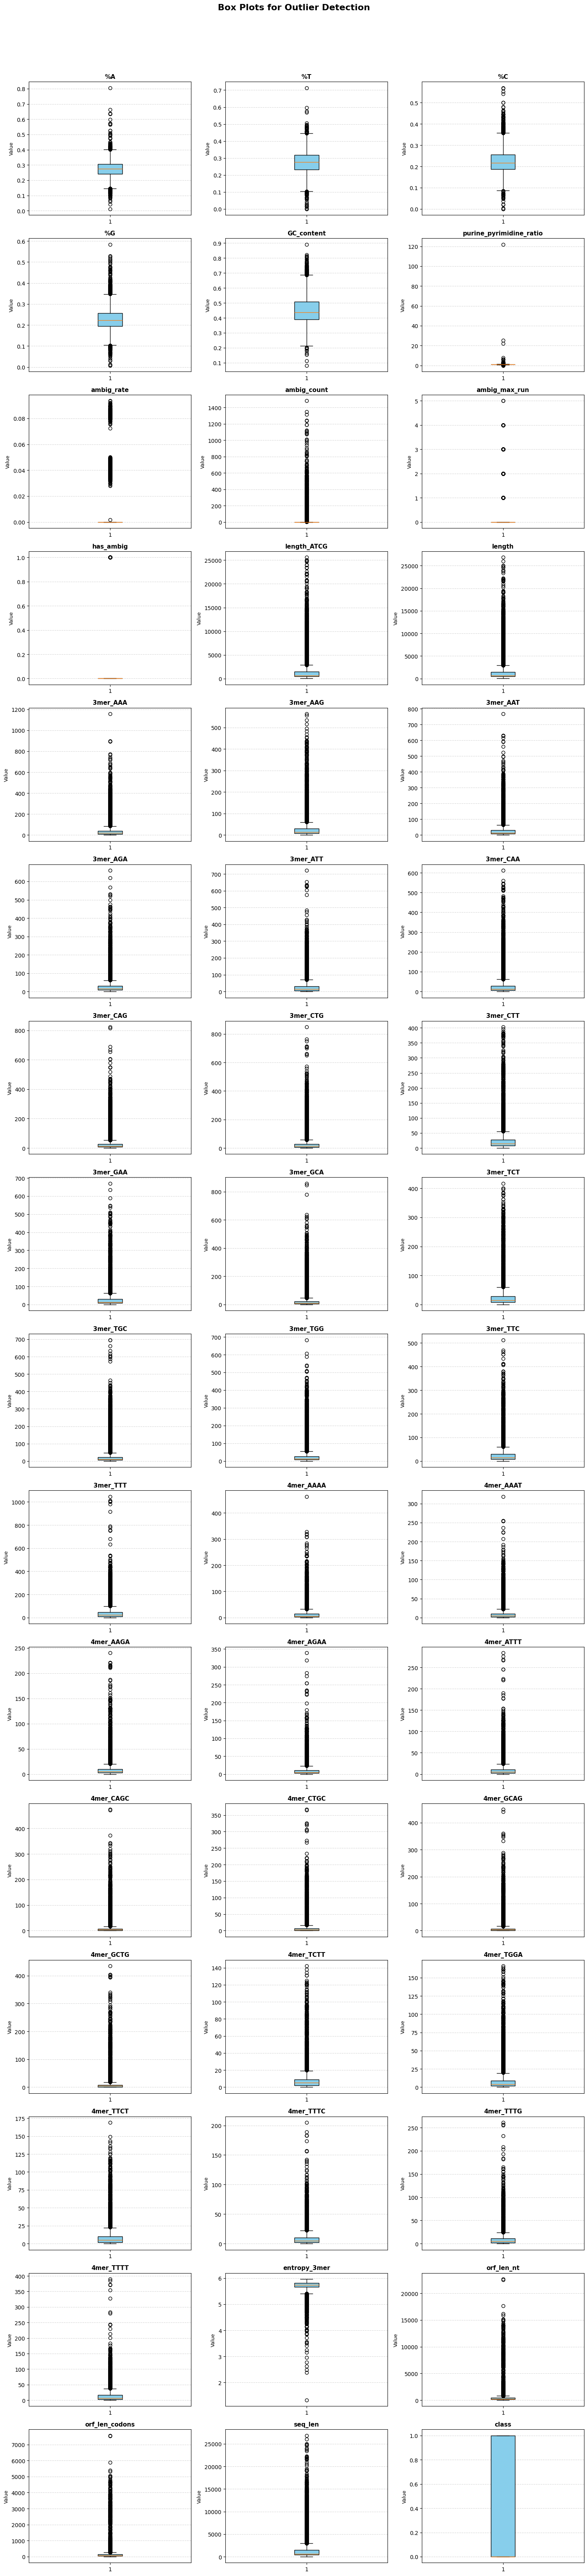

In [169]:
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"Total numeric columns: {len(numerical_cols)}")

n_cols = 3
n_rows = int((len(numerical_cols) + n_cols - 1) / n_cols)
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for idx, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    plt.boxplot(df_cleaned[col], vert=True, patch_artist=True, boxprops=dict(facecolor="#87CEEB", color='black'))
    plt.title(col, fontsize=11, fontweight='bold')
    plt.ylabel('Value', fontsize=9)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle('Box Plots for Outlier Detection', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [170]:
outlier_summary = {}
for col in numerical_cols:
    q1 = df_cleaned[col].quantile(0.25)
    q3 = df_cleaned[col].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    n_outliers = ((df_cleaned[col] < lower) | (df_cleaned[col] > upper)).sum()
    outlier_summary[col] = n_outliers

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['outlier_count'])
outlier_df['% of total'] = 100 * outlier_df['outlier_count'] / len(df_cleaned)
print(outlier_df.sort_values('outlier_count', ascending=False))

                         outlier_count  % of total
ambig_rate                        2667   18.668627
ambig_count                       2667   18.668627
has_ambig                         2667   18.668627
ambig_max_run                     2667   18.668627
orf_len_nt                        1772   12.403752
orf_len_codons                    1772   12.403752
3mer_GCA                          1735   12.144757
length_ATCG                       1721   12.046759
seq_len                           1709   11.962761
length                            1709   11.962761
3mer_TGC                          1705   11.934761
3mer_CAG                          1686   11.801764
3mer_AAG                          1629   11.402772
3mer_CAA                          1627   11.388772
3mer_TGG                          1624   11.367773
3mer_CTT                          1604   11.227775
3mer_CTG                          1581   11.066779
3mer_AGA                          1577   11.038779
4mer_TGGA                      

## Feature Scaling

In [171]:
pip install scikit-learn

In [172]:
from sklearn.preprocessing import RobustScaler

In [173]:
numerical_cols.remove('class')

In [174]:
scaler = RobustScaler()
df_cleaned[numerical_cols] = scaler.fit_transform(df_cleaned[numerical_cols])

print(df_cleaned.head())

                 name        %A        %T        %C        %G  GC_content  \
0  ENSDART00000138379 -0.104256  0.050347  0.158715  0.019342    0.122878   
1  ENSDART00000075994 -0.215256 -0.042397  0.228697  0.187188    0.249116   
2  ENSDART00000153938  0.464296 -0.073732 -0.102521 -0.108501   -0.092075   
3  ENSDART00000152541  1.224778  0.579457 -1.002830 -0.815465   -0.969763   
4  ENSDART00000139170  0.683394  0.117212 -0.251423 -0.438882   -0.346928   

   purine_pyrimidine_ratio  ambig_rate  ambig_count  ambig_max_run  ...  \
0                -0.165724    0.045968        118.0            2.0  ...   
1                -0.106732    0.042929         34.0            2.0  ...   
2                 0.386492    0.000000          0.0            0.0  ...   
3                 0.495001    0.000000          0.0            0.0  ...   
4                 0.259488    0.000000          0.0            0.0  ...   

   4mer_TGGA  4mer_TTCT  4mer_TTTC  4mer_TTTG  4mer_TTTT  entropy_3mer  \
0   1.428571

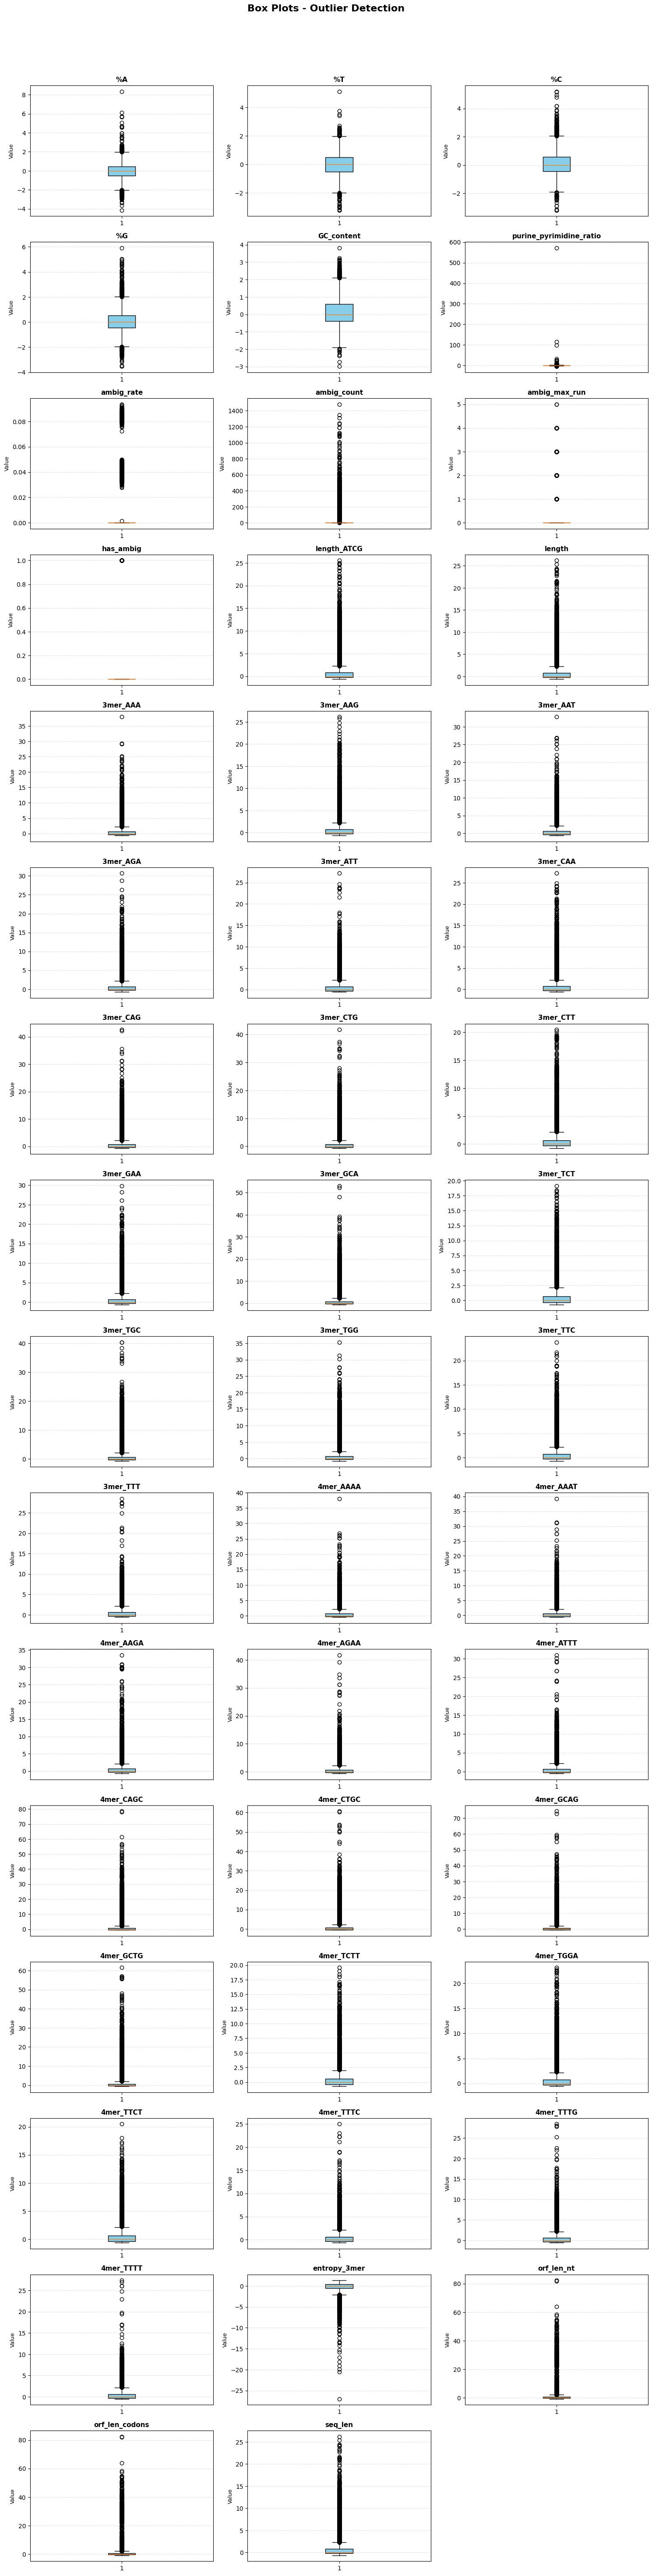

In [175]:
# rebuild the numeric list
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns.tolist()
for c in ['class', 'Unnamed: 0']:
    if c in numerical_cols:
        numerical_cols.remove(c)

n_features = len(numerical_cols)
ncols = 3
nrows = int(np.ceil(n_features / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3.6*nrows), squeeze=False)

for i, col in enumerate(numerical_cols):
    ax = axes.flat[i]
    ax.boxplot(df_cleaned[col], vert=True, patch_artist=True,
               boxprops=dict(facecolor="#87CEEB", edgecolor="black"))
    ax.set_title(col, fontsize=11, fontweight='bold')
    ax.set_ylabel('Value', fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

for j in range(i+1, nrows*ncols):
    axes.flat[j].set_visible(False)

fig.suptitle('Box Plots - Outlier Detection', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [176]:
## Uncomment if you want to download "features_df.csv" and "features_test.csv"
## from google.colab import files
## files.download("features_df.csv")
## files.download("features_test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# CNN Implementation

## Quick Guide (how to run)
- Upload test.csv, training_class.csv & training.fa (these files should already be present if you run this .ipynb file from the beginning)
- From the Model & Dataset Folder in our Github, upload the files CNN_final_model.h5 & CNN_best_threshold.txt

In [177]:
# Optional - uncomment if you HAVE not uploaded "CNN_final_model.h5"
# & "CNN_best_threshold.txt" at the beginning

# from google.colab import files
# uploaded = files.upload()

## Helper functions for preprocessing data and model

In [178]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras.models import (Sequential, load_model)
from keras.layers import (Conv1D, MaxPooling1D, BatchNormalization,
                          Dropout, GlobalAveragePooling1D, Dense, Flatten)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, matthews_corrcoef,
    accuracy_score, recall_score
)
import matplotlib.pyplot as plt
from google.colab import (files, drive)
import pickle

#Convert RNA into one hot encoded-vectors (Helper function)
base_to_onehot = {
    'A': np.array([1, 0, 0, 0]),
    'U': np.array([0, 1, 0, 0]),
    'G': np.array([0, 0, 1, 0]),
    'C': np.array([0, 0, 0, 1])
}

# Precomputed one-hot encoding for all IUPAC codes
IUPAC_RNA_ONEHOT = {
    'A': base_to_onehot['A'],
    'U': base_to_onehot['U'],
    'G': base_to_onehot['G'],
    'C': base_to_onehot['C'],
    'T': base_to_onehot['U'],  # T -> U
    'R': (base_to_onehot['A'] + base_to_onehot['G']) / 2,
    'Y': (base_to_onehot['C'] + base_to_onehot['U']) / 2,
    'S': (base_to_onehot['G'] + base_to_onehot['C']) / 2,
    'W': (base_to_onehot['A'] + base_to_onehot['U']) / 2,
    'K': (base_to_onehot['G'] + base_to_onehot['U']) / 2,
    'M': (base_to_onehot['A'] + base_to_onehot['C']) / 2,
    'B': (base_to_onehot['C'] + base_to_onehot['G'] + base_to_onehot['U']) / 3,
    'D': (base_to_onehot['A'] + base_to_onehot['G'] + base_to_onehot['U']) / 3,
    'H': (base_to_onehot['A'] + base_to_onehot['C'] + base_to_onehot['U']) / 3,
    'V': (base_to_onehot['A'] + base_to_onehot['C'] + base_to_onehot['G']) / 3,
    'N': (base_to_onehot['A'] + base_to_onehot['U'] + base_to_onehot['G'] + base_to_onehot['C']) / 4
}

def one_hot_encode_sequences(sequences, maxlen=1500):
    num_sequences = len(sequences)
    # Initialize output array with zeros (padding)
    X = np.zeros((num_sequences, maxlen, 4), dtype=float)

    for i, seq in enumerate(sequences):
        for j, base in enumerate(seq[:maxlen]):  # Only first maxlen nucleotides
            onehot = IUPAC_RNA_ONEHOT.get(base.upper(), IUPAC_RNA_ONEHOT['N'])
            X[i, j] = onehot

    return X

# Load FASTA (Helper function)
def load_fasta(filepath):
    sequences = {}
    res = []
    count = 0
    with open(filepath, 'r') as f:
        seq_id = None
        seq_chunks = []
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith('>'):
                if seq_id:
                    sequences[seq_id] = ''.join(seq_chunks)
                seq_id = line[1:].split()[0]
                seq_chunks = []
            else:
                seq_chunks.append(line.upper())
        if seq_id and seq_chunks:
             sequences[seq_id] = ''.join(seq_chunks)
    for name in sequences:
        res.append(sequences[name])

    return res ## returns fasta file converted to an array of sequences

# Load CSV labels (Helper function)
def load_labels(csv_path):
    labels = []
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]

    for _, row in df.iterrows():

        labels.append(row['class'])
    return labels

#load mRNA in string form (Helper function)
def load_sequences(csv_path):
    seq = []

    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]

    for _, row in df.iterrows():
        seq.append(row['sequence'])
    return seq    ##array of the mRNA in string form

#Helper function
def get_dataset(seq_array, labels):
    X = one_hot_encode_sequences(seq_array)
    y = np.array(labels, dtype=np.int32)
    return X, y       ## y[n] corresponds to the class for X[n]

#CNN model used
def build_mrna_cnn(input_shape):
    model = Sequential([
    # 1st Convolutional Block
        Conv1D(64, 7, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        # 2nd Convolutional Block
        Conv1D(128, 5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        # Global pooling and dense layers
        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

## Preprocessing the training data and loading the trained model

In [179]:
# Load training sequences from the FASTA file using the corrected function
cnn_seq_train = load_fasta("training.fa")
# Load training labels from the CSV file
cnn_label_train = load_labels("training_class.csv")


# Get dataset in the required format for the model
cnn_X_all, cnn_y_all = get_dataset(cnn_seq_train, cnn_label_train)

# Split the data into training and validation sets
cnn_X_train, cnn_X_val, cnn_y_train, cnn_y_val = train_test_split(
    cnn_X_all, cnn_y_all,
    test_size=0.20,
    random_state=42,
    stratify=cnn_y_all
)

# Load test data from the CSV file
cnn_test_csv_path = "test.csv"
cnn_seq_test   = load_sequences(cnn_test_csv_path)
cnn_label_test = load_labels(cnn_test_csv_path)

#test dataset
cnn_X_test, cnn_y_test = get_dataset(cnn_seq_test, cnn_label_test)

cnn_model = load_model("CNN_final_model.h5")

# Load the threshold
with open("CNN_best_threshold.txt", "r") as f:
    cnn_best_threshold = float(f.read())

## Using model to predict the test set

35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 398ms/step
Accuracy: 0.8865
Sensitivity: 0.8877
Specificity: 0.8854
MCC: 0.7731


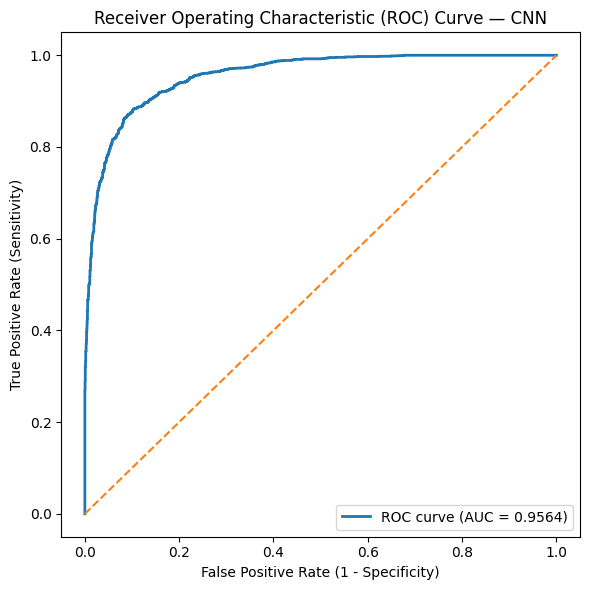

In [180]:
cnn_y_pred_probs = cnn_model.predict(cnn_X_test, batch_size=128).ravel() #predicted probs from model
cnn_y_pred = (cnn_y_pred_probs >= cnn_best_threshold).astype(int) #1s and 0s


# Compute confusion matrix
cnn_tn, cnn_fp, cnn_fn, cnn_tp = confusion_matrix(cnn_y_test, cnn_y_pred).ravel()

cnn_accuracy = accuracy_score(cnn_y_test, cnn_y_pred)
cnn_sensitivity = cnn_tp / (cnn_tp + cnn_fn)
cnn_specificity = cnn_tn / (cnn_tn + cnn_fp)
cnn_mcc = matthews_corrcoef(cnn_y_test, cnn_y_pred)

print(f"Accuracy: {cnn_accuracy:.4f}")
print(f"Sensitivity: {cnn_sensitivity:.4f}")
print(f"Specificity: {cnn_specificity:.4f}")
print(f"MCC: {cnn_mcc:.4f}")

# ------------------------
# 5️⃣ ROC Curve
# ------------------------
cnn_fpr, cnn_tpr, cnn_thresholds = roc_curve(cnn_y_test, cnn_y_pred_probs)
cnn_roc_auc = auc(cnn_fpr, cnn_tpr)

plt.figure(figsize=(6, 6))
plt.plot(cnn_fpr, cnn_tpr, lw=2, label=f'ROC curve (AUC = {cnn_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve — CNN')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# RF Implementation

## Quick Guide (how to run)
1. Download `features_df.csv` and `features_test.csv` from Model & Dataset Folder in our Github, and upload them here (if you run this .ipynb file from the beginning, skip this step)
2. Run cells from top to bottom — no manual edits needed.
3. Outputs:
   - `rf_predictions.csv`
   - `RF_model.pkl`
   - `Plots` (Confusion Matrix, ROC, PR)


## Import Necessary Libraries

In [181]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    matthews_corrcoef,
    roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold

## Upload features_df.csv and features_test.csv (optional)



In [182]:
# Optional - uncomment if you DID not run the data processing blocks
# from google.colab import files
# uploaded = files.upload()

## Reproducibility & Environment

In [183]:
import sys, sklearn, numpy, pandas, random
random.seed(42)
numpy.random.seed(42)

In [184]:
# versions + seeds check
print({
    "python": sys.version.split()[0],
    "numpy": numpy.__version__,
    "pandas": pandas.__version__,
    "sklearn": sklearn.__version__,
    "seed": 42
})

{'python': '3.12.12', 'numpy': '2.0.2', 'pandas': '2.2.2', 'sklearn': '1.6.1', 'seed': 42}


## Paths and Parameters

In [185]:
# files path

TRAIN_PATH = "features_df.csv"
TEST_PATH  = "features_test.csv"
OUTPUT_CSV = "rf_predictions.csv"

# experiment control

RANDOM_STATE = 42
VALIDATION_SIZE = 0.20
ZERO_VARIANCE_THRESHOLD = 0.0

# RF hyperparameters

N_TREES = 400
MAX_DEPTH = 20
MAX_SAMPLES_PER_TREE = 0.60
MAX_FEATURES_PER_SPLIT = "sqrt"
CLASS_WEIGHT_MODE = "balanced_subsample"

## Codes

In [186]:
# 1) helper functions

## finds threshold (0–1) that gives best Matthews Corr. Coefficient (MCC).

def pick_threshold_by_mcc(y_true, y_prob):
    thresholds = np.linspace(0, 1, 1001)
    best_thr, best_mcc = 0.5, -1.0
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        mcc = matthews_corrcoef(y_true, y_pred)
        if mcc > best_mcc:
            best_mcc = mcc
            best_thr = t
    return best_thr, best_mcc

## realign df_new to match training column order exactly.
## missing columns are added as 0 and extra columns are dropped.

def align_to_train_columns(df_new, train_cols_in_order):
    return df_new.reindex(columns=train_cols_in_order, fill_value=0.0)

In [187]:
# 2) load and prepare data

rf_train_df = pd.read_csv(TRAIN_PATH)

rf_non_feature_cols = [c for c in ["name"] if c in rf_train_df.columns]
rf_X_raw = rf_train_df.drop(columns=["class"] + rf_non_feature_cols, errors="ignore")

rf_y_all = rf_train_df["class"].astype(int).to_numpy()
rf_train_original_cols = list(rf_X_raw.columns)

In [188]:
# 3) remove zero-variance features

rf_var_selector = VarianceThreshold(threshold=ZERO_VARIANCE_THRESHOLD)
rf_X_all = pd.DataFrame(
    rf_var_selector.fit_transform(rf_X_raw),
    columns=[col for col, keep in zip(rf_train_original_cols, rf_var_selector.get_support()) if keep]
)
rf_selected_feature_names = list(rf_X_all.columns)

# ensure numeric types and no NaNs

rf_X_all = rf_X_all.apply(pd.to_numeric, errors="coerce").fillna(0.0)

In [189]:
# 4) split (80/20) for validation

rf_X_train, rf_X_val, rf_y_train, rf_y_val = train_test_split(
    rf_X_all, rf_y_all,
    test_size=VALIDATION_SIZE,
    stratify=rf_y_all,
    random_state=RANDOM_STATE
)

In [190]:
# 5) train first RF for threshold tuning

rf_val_clf = RandomForestClassifier(
    n_estimators=N_TREES,
    max_depth=MAX_DEPTH,
    max_features=MAX_FEATURES_PER_SPLIT,
    bootstrap=True,
    max_samples=MAX_SAMPLES_PER_TREE,
    class_weight=CLASS_WEIGHT_MODE,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_val_clf.fit(rf_X_train, rf_y_train)

rf_val_prob = rf_val_clf.predict_proba(rf_X_val)[:, 1]
rf_best_thr, rf_best_mcc = pick_threshold_by_mcc(rf_y_val, rf_val_prob)

In [191]:
# 6) retrain on all training data

rf_full_clf = RandomForestClassifier(
    n_estimators=N_TREES,
    max_depth=MAX_DEPTH,
    max_features=MAX_FEATURES_PER_SPLIT,
    bootstrap=True,
    max_samples=MAX_SAMPLES_PER_TREE,
    class_weight=CLASS_WEIGHT_MODE,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_full_clf.fit(rf_X_all, rf_y_all)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                       max_samples=0.6, n_estimators=400, n_jobs=-1,
                       random_state=42)

In [192]:
# 7) prepare test data

rf_test_df = pd.read_csv(TEST_PATH)
rf_id_col = "name" if "name" in rf_test_df.columns else None

rf_X_test_raw = rf_test_df.drop(columns=[c for c in ["name", "class"] if c in rf_test_df.columns], errors="ignore")

# align directly to the selected features

rf_X_test_selected = align_to_train_columns(rf_X_test_raw, rf_selected_feature_names)
rf_X_test_selected = rf_X_test_selected.apply(pd.to_numeric, errors="coerce").fillna(0.0)

# same columns/order as training-selected features

assert list(rf_X_all.columns) == list(rf_selected_feature_names)
assert list(rf_X_test_selected.columns) == list(rf_selected_feature_names)

In [193]:
# 8) predict test set

rf_test_prob = rf_full_clf.predict_proba(rf_X_test_selected)[:, 1]
rf_test_pred = (rf_test_prob >= rf_best_thr).astype(int)

In [194]:
# 9) save predictions

rf_id_values = rf_test_df[rf_id_col] if rf_id_col else np.arange(len(rf_test_df))
rf_id_header = rf_id_col if rf_id_col else "row_id"

rf_out = pd.DataFrame({
    rf_id_header: rf_id_values,
    "pred": rf_test_pred,
    "prob": rf_test_prob,
    "used_threshold": rf_best_thr
})

## Uncomment if you want to download the predictions
## rf_out.to_csv(OUTPUT_CSV, index=False)
## print("\nPredictions exported as:", OUTPUT_CSV)

In [195]:
# 10) results validation

rf_val_pred = (rf_val_prob >= rf_best_thr).astype(int)
rf_mcc_val = matthews_corrcoef(rf_y_val, rf_val_pred)
rf_cm = confusion_matrix(rf_y_val, rf_val_pred, labels=[0, 1])
rf_tn, rf_fp, rf_fn, rf_tp = rf_cm.ravel()

rf_acc  = (rf_tp + rf_tn) / max(1, (rf_tp + rf_tn + rf_fp + rf_fn))
rf_sens = rf_tp / max(1, (rf_tp + rf_fn))
rf_spec = rf_tn / max(1, (rf_tn + rf_fp))
rf_prec = rf_tp / max(1, (rf_tp + rf_fp))
rf_rocA = roc_auc_score(rf_y_val, rf_val_prob)

print("\n==== RF Validation Results ====")
print(f"Best threshold: {rf_best_thr:.2f}")
print(
    f"ACC={rf_acc:.5f}  SEN={rf_sens:.5f}  SPEC={rf_spec:.5f}  "
    f"PREC={rf_prec:.5f}  MCC={rf_best_mcc:.5f} (chk {rf_mcc_val:.5f})  ROC-AUC={rf_rocA:.5f}"
)
print("Confusion matrix [[TN FP],[FN TP]]:\n", rf_cm)

print("\nValidation probability range:",
      float(rf_val_prob.min()), "→", float(rf_val_prob.max()),
      "| median =", float(np.median(rf_val_prob)))
print("Unique predictions (label: count):",
      dict(zip(*np.unique(rf_val_pred, return_counts=True))))


==== RF Validation Results ====
Best threshold: 0.31
ACC=0.98321  SEN=0.99704  SPEC=0.97561  PREC=0.95735  MCC=0.96413 (chk 0.96413)  ROC-AUC=0.99903
Confusion matrix [[TN FP],[FN TP]]:
 [[1800   45]
 [   3 1010]]

Validation probability range: 0.0 → 1.0 | median = 0.015
Unique predictions (label: count): {np.int64(0): np.int64(1803), np.int64(1): np.int64(1055)}


In [196]:
# 11) prediction summary

# probability distribution
print(f"Probability range: {rf_test_prob.min():.4f} → {rf_test_prob.max():.4f}")
print(f"Median probability: {np.median(rf_test_prob):.4f}")
print(f"Mean probability:   {np.mean(rf_test_prob):.4f}")
print(f"Std deviation:      {np.std(rf_test_prob):.4f}")

# prediction

rf_unique_labels, rf_counts = np.unique(rf_test_pred, return_counts=True)
rf_total = rf_counts.sum()
for rf_label, rf_count in zip(rf_unique_labels, rf_counts):
    rf_percent = 100 * rf_count / rf_total
    rf_label_name = "mRNA (1)" if rf_label == 1 else "non-mRNA (0)"
    print(f"{rf_label_name:<12}: {rf_count:6d} ({rf_percent:5.2f}%)")

# threshold

print(f"\nDecision threshold used: {rf_best_thr:.4f}")
print(f"Total predictions: {len(rf_test_pred)}")

Probability range: 0.0000 → 1.0000
Median probability: 0.5275
Mean probability:   0.5008
Std deviation:      0.4678
non-mRNA (0):   2199 (49.80%)
mRNA (1)    :   2217 (50.20%)

Decision threshold used: 0.3130
Total predictions: 4416


## Plotting Relevant Diagrams

In [197]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

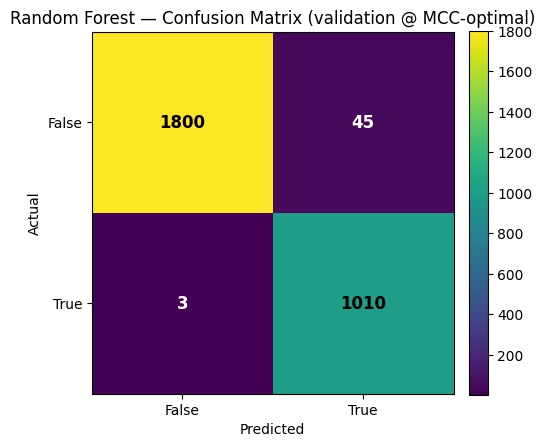

In [198]:
# Confusion Matrix Heatmap

fig = plt.figure(figsize=(5.2, 4.6))
ax = plt.gca()
im = ax.imshow(rf_cm, interpolation="nearest", cmap="viridis")
ax.set_title("Random Forest — Confusion Matrix (validation @ MCC-optimal)")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["False", "True"])
ax.set_yticklabels(["False", "True"])
norm = plt.Normalize(vmin=im.get_array().min(), vmax=im.get_array().max())
for i in range(rf_cm.shape[0]):
    for j in range(rf_cm.shape[1]):
        val = rf_cm[i, j]
        color = "white" if norm(val) < 0.5 else "black"
        ax.text(j, i, f"{val}", va="center", ha="center",
                fontsize=12, fontweight="bold", color=color)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=10)
fig.tight_layout()
plt.show()

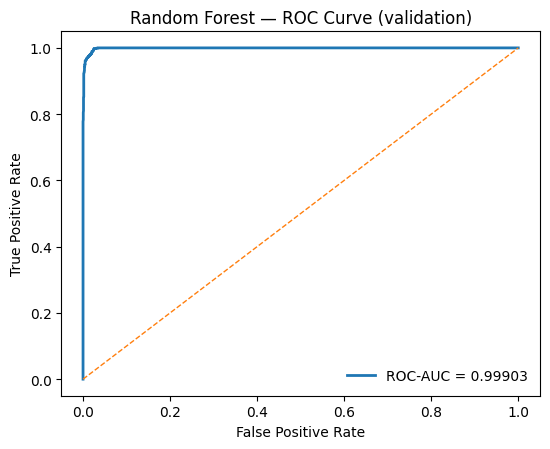

In [199]:
# ROC Curve

rf_fpr, rf_tpr, _ = roc_curve(rf_y_val, rf_val_prob)
rf_rocA_curve = auc(rf_fpr, rf_tpr)
plt.figure(figsize=(5.6, 4.6))
plt.plot(rf_fpr, rf_tpr, linewidth=2, label=f"ROC-AUC = {rf_rocA_curve:.5f}")
plt.plot([0,1],[0,1], "--", linewidth=1)
plt.title("Random Forest — ROC Curve (validation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
plt.show()

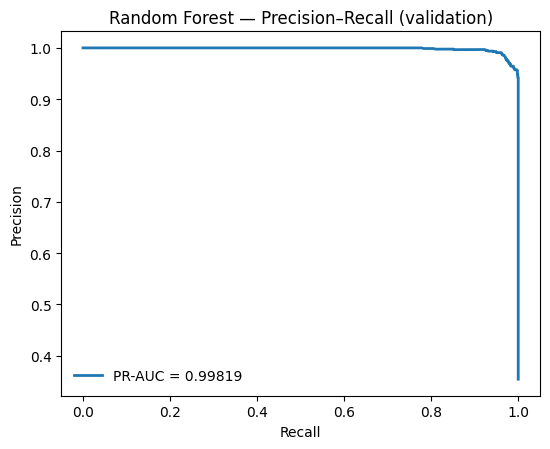

In [200]:
# Precision - Recall Curve

rf_prec_curve, rf_rec_curve, _ = precision_recall_curve(rf_y_val, rf_val_prob)
from sklearn.metrics import auc as sk_auc
rf_prA = sk_auc(rf_rec_curve, rf_prec_curve)
plt.figure(figsize=(5.6, 4.6))
plt.plot(rf_rec_curve, rf_prec_curve, linewidth=2, label=f"PR-AUC = {rf_prA:.5f}")
plt.title("Random Forest — Precision–Recall (validation)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left", frameon=False)
plt.tight_layout()
plt.show()

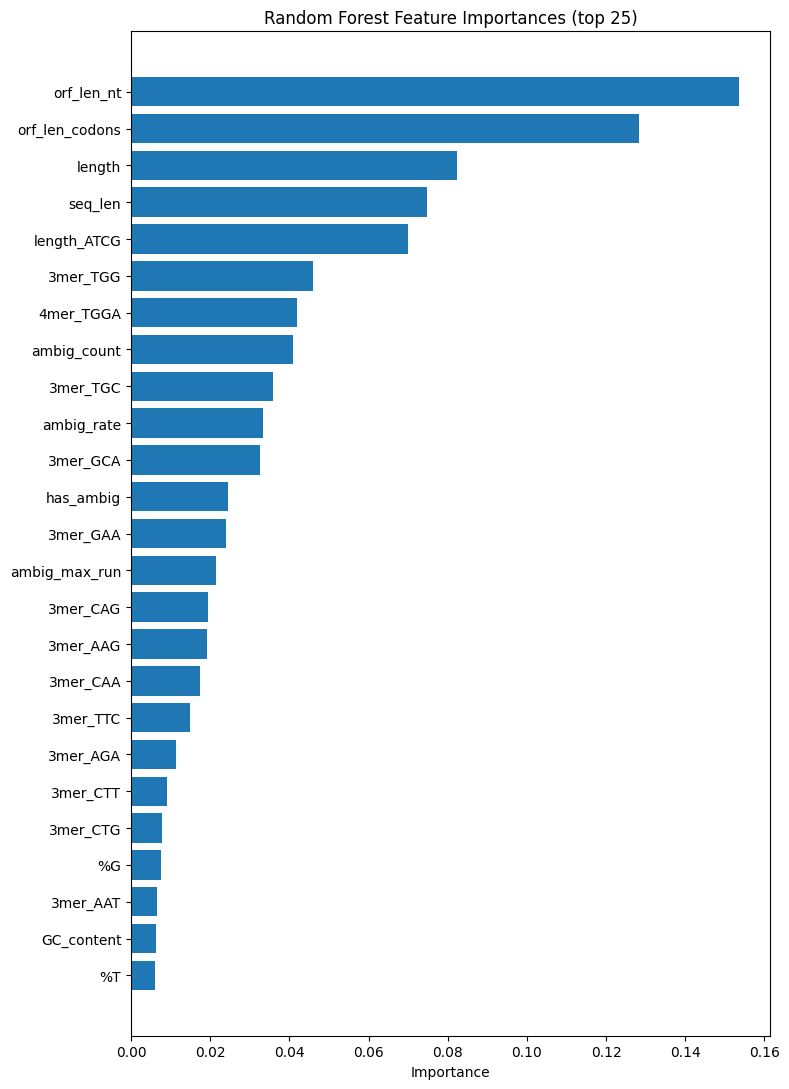

In [201]:
# Feature Importances

rf_imp = rf_full_clf.feature_importances_
rf_idx = np.argsort(rf_imp)[::-1][:25]
plt.figure(figsize=(8, 0.32*len(rf_idx)+3))
plt.barh(range(len(rf_idx)), rf_imp[rf_idx][::-1])
plt.yticks(range(len(rf_idx)), [list(rf_X_all.columns)[i] for i in rf_idx][::-1])
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances (top 25)")
plt.tight_layout()
plt.show()

## Saving The Trained Model

In [202]:
import joblib
joblib.dump(rf_full_clf, "RF_model.pkl")

['RF_model.pkl']

# LSTM Implementation

## Import Libraries

In [204]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             matthews_corrcoef,
                             classification_report, roc_curve)
import pandas as pd

## Data Preparation

Since LSTMs require numerical inputs, we encode each character in the sequence as a vector representing the probability distribution over nucleotides (A, C, G, T). This converts the string sequence into a numerical form suitable for LSTM training.

In [205]:
iupac_encoding = {
    'A': [1, 0, 0, 0],
    'C': [0, 1, 0, 0],
    'G': [0, 0, 1, 0],
    'T': [0, 0, 0, 1],
    'U': [0, 0, 0, 1],
    'R': [0.5, 0, 0.5, 0],
    'Y': [0, 0.5, 0, 0.5],
    'S': [0, 0.5, 0.5, 0],
    'W': [0.5, 0, 0, 0.5],
    'K': [0, 0, 0.5, 0.5],
    'M': [0.5, 0.5, 0, 0],
    'B': [0, 1/3, 1/3, 1/3],
    'D': [1/3, 0, 1/3, 1/3],
    'H': [1/3, 1/3, 0, 1/3],
    'V': [1/3, 1/3, 1/3, 0],
    'N': [0.25, 0.25, 0.25, 0.25],
    '.': [0, 0, 0, 0],
    '-': [0, 0, 0, 0]
}

def encode_sequence(seq):
    return np.array([iupac_encoding.get(base, [0, 0, 0, 0]) for base in seq], dtype='float32')
X = [encode_sequence(seq) for seq in df['name']]
y = df['class'].values

In [206]:
## Padding sequences to the same length:
maxlen = 500
X = pad_sequences(X, maxlen=maxlen, padding='post', dtype='float32')

## Evaluation Metrics Graph of the Best Model

### Loading Model & Preparing Test Dataset
- To run the model, "LSTM_model.h5" from GitHub is required.

In [207]:
# Optional - uncomment if you HAVE not uploaded "LSTM_model.h5" at the beginning
# from google.colab import files
# uploaded = files.upload()

In [208]:
# Loading model
import tensorflow as tf
model = tf.keras.models.load_model('LSTM_model.h5')

In [209]:
# Preparing test dataset

test_df = pd.read_csv('test.csv')
X_test = [encode_sequence(seq) for seq in test_df['sequence']]
y_test = test_df['class'].values

X_test = pad_sequences(X_test, maxlen=500, padding='post', dtype='float32')
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


138/138 ━━━━━━━━━━━━━━━━━━━━ 28s 205ms/step


In [210]:
# Check evaluation metrics:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

In [211]:
print("\n=== Model Evaluation Metrics ===")
print(f"Accuracy:     {accuracy:.4f}")
print(f"Precision:    {precision:.4f}")
print(f"Sensitivity:  {sensitivity:.4f}")
print(f"MCC:          {mcc:.4f}")
print(f"ROC-AUC:      {roc_auc:.4f}")
print(f"Specificity:  {specificity:.4f}")


=== Model Evaluation Metrics ===
Accuracy:     0.6019
Precision:    0.6102
Sensitivity:  0.5643
MCC:          0.2044
ROC-AUC:      0.6650
Specificity:  0.6395


###Plotting ROC curve for the model

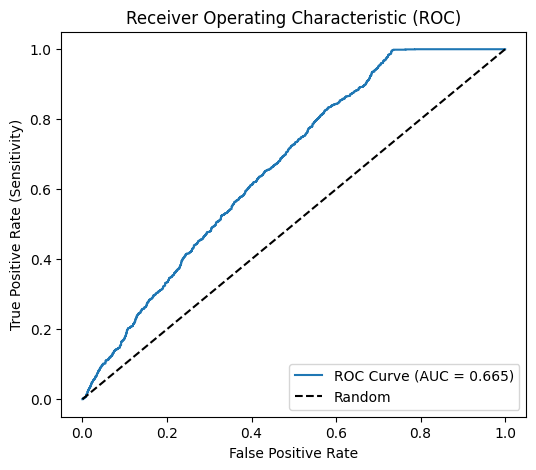

In [212]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# LR Implementation

- Download features_df.csv and features_test.csv from Model & Dataset Folder in our Github (if you run this .ipynb file from the beginning, skip this step)
- Upload both .csv files for model training and testing.

##Import

In [213]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_recall_curve, auc as sk_auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

## LR Paths and Hyperparameters

In [214]:
TRAIN_PATH = "features_df.csv"
TEST_PATH  = "features_test.csv"
OUTPUT_CSV = "lr_predictions.csv"

RANDOM_STATE = 7
VALIDATION_SIZE = 0.20
ZERO_VARIANCE_THRESHOLD = 0.0

PENALTY = "l2"
C = 1.0
MAX_ITERS = 5000
SOLVER = "liblinear"
CLASS_WEIGHT = "balanced"

## Upload features_df.csv and features_test.csv (optional)

In [215]:
# Optional - uncomment if you DID not run the data processing blocks
# from google.colab import files
# uploaded = files.upload()

## Code

In [216]:
# Helper functions
def pick_threshold_by_mcc(y_true, y_prob):
    """Find the probability threshold (0–1) that maximizes MCC."""
    thresholds = np.linspace(0, 1, 1001)
    opt_thr, best_mcc = 0.5, -1.0
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        mcc = matthews_corrcoef(y_true, y_pred)
        if mcc > best_mcc:
            best_mcc, opt_thr = mcc, t
    return opt_thr, best_mcc

def align_to_train_columns(df_new, train_cols_in_order):
    return df_new.reindex(columns=train_cols_in_order, fill_value=0.0)

In [217]:
# Build a single pipeline: scale -> logistic regression
lr_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clf", LogisticRegression(
        penalty=PENALTY,
        C=C,
        solver=SOLVER,
        class_weight=CLASS_WEIGHT,
        max_iter=MAX_ITERS,
        random_state=RANDOM_STATE,
    ))
])

def pick_threshold_by_mcc(y_true, y_prob):
    """Find the probability threshold (0–1) that maximizes MCC."""
    thresholds = np.linspace(0, 1, 1001)
    opt_thr, best_mcc = 0.5, -1.0
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        mcc = matthews_corrcoef(y_true, y_pred)
        if mcc > best_mcc:
            best_mcc, opt_thr = mcc, t
    return opt_thr, best_mcc

def align_to_train_columns(df_new, train_cols_in_order):
    return df_new.reindex(columns=train_cols_in_order, fill_value=0.0)

In [218]:
# Load and prepare training data
train_df = pd.read_csv(TRAIN_PATH)
# Identify non-feature columns to drop from X
non_feature_cols = [c for c in ["name"] if c in train_df.columns]

X_raw = train_df.drop(columns=["class"] + non_feature_cols, errors="ignore")
y_all = train_df["class"].astype(int).to_numpy()

train_original_cols = list(X_raw.columns)

In [219]:
# Remove zero-variance features (keeps col positions)
selector = VarianceThreshold(threshold=ZERO_VARIANCE_THRESHOLD)
X_all = pd.DataFrame(
    selector.fit_transform(X_raw),
    columns=[col for col, keep in zip(train_original_cols, selector.get_support()) if keep]
)
selected_feature_names = list(X_all.columns)

# Ensure numeric & no NaNs
X_all = X_all.apply(pd.to_numeric, errors="coerce").fillna(0.0)

In [220]:
# Split raw features
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=VALIDATION_SIZE,
    stratify=y_all,
    random_state=RANDOM_STATE
)

In [221]:
# Train pipeline first for threshold tuning
lr_pipe.fit(X_train_raw, y_train)
val_prob = lr_pipe.predict_proba(X_val_raw)[:, 1]
opt_thr, best_mcc = pick_threshold_by_mcc(y_val, val_prob)

In [222]:
# Prepare test data
test_df = pd.read_csv(TEST_PATH)
id_col = "name" if "name" in test_df.columns else None

X_test_raw = test_df.drop(columns=[c for c in ["name", "class"] if c in test_df.columns], errors="ignore")

# Align exactly to training-selected features (add missing as 0, drop extras)
X_test_selected = align_to_train_columns(X_test_raw, selected_feature_names)
X_test_selected = X_test_selected.apply(pd.to_numeric, errors="coerce").fillna(0.0)

# Predict with pipeline
test_prob = lr_pipe.predict_proba(X_test_selected)[:, 1]
test_pred = (test_prob >= opt_thr).astype(int)

In [223]:
# Save predictions
id_values = test_df[id_col] if id_col else np.arange(len(test_df))
id_header = id_col if id_col else "row_id"

out = pd.DataFrame({
    id_header: id_values,
    "pred": test_pred,
    "prob": test_prob,
    "used_threshold": opt_thr
})

## Uncomment if you want to download the predictions
## out.to_csv(OUTPUT_CSV, index=False)
## print("\nPredictions exported as:", OUTPUT_CSV)

In [224]:
# Validation report
val_pred = (val_prob >= opt_thr).astype(int)
mcc_val = matthews_corrcoef(y_val, val_pred)
cm = confusion_matrix(y_val, val_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

acc  = (tp + tn) / max(1, (tp + tn + fp + fn))
sens = tp / max(1, (tp + fn))         # recall / sensitivity
spec = tn / max(1, (tn + fp))         # specificity
rocA = roc_auc_score(y_val, val_prob)

print("\n==== Validation Results ====")
print(f"Best threshold: {opt_thr:.2f}")
print(f"ACC={acc:.3f}  SEN={sens:.3f}  SPEC={spec:.3f}  MCC={mcc_val:.3f}   ROC-AUC={rocA:.3f}")
print("Confusion matrix [TN FP; FN TP]:\n", cm)

print("\nValidation probability range:",
      float(val_prob.min()), "→", float(val_prob.max()),
      "| median =", float(np.median(val_prob)))
print("Unique predictions (label: count):",
      dict(zip(*np.unique(val_pred, return_counts=True))))


==== Validation Results ====
Best threshold: 0.42
ACC=0.982  SEN=0.992  SPEC=0.976  MCC=0.961   ROC-AUC=0.998
Confusion matrix [TN FP; FN TP]:
 [[1801   44]
 [   8 1005]]

Validation probability range: 8.058224071241975e-12 → 1.0 | median = 0.03286068659383458
Unique predictions (label: count): {np.int64(0): np.int64(1809), np.int64(1): np.int64(1049)}


In [225]:
# Prediction summary on TEST
print("\n--- Prediction summary (test) ---")
print(f"Probability range: {test_prob.min():.4f} → {test_prob.max():.4f}")
print(f"Median probability: {np.median(test_prob):.4f}")
print(f"Mean probability:   {np.mean(test_prob):.4f}")
print(f"Std deviation:      {np.std(test_prob):.4f}")

unique_labels, counts = np.unique(test_pred, return_counts=True)
total = counts.sum()
for label, count in zip(unique_labels, counts):
    pct = 100.0 * count / total
    label_name = "mRNA (1)" if label == 1 else "non-mRNA (0)"
    print(f"{label_name:12}: {count:6d} ({pct:5.2f}%)")

print(f"\nDecision threshold used: {opt_thr:.4f}")
print(f"Total predictions: {len(test_pred)}")


--- Prediction summary (test) ---
Probability range: 0.0000 → 1.0000
Median probability: 0.5131
Mean probability:   0.5091
Std deviation:      0.4697
non-mRNA (0):   2181 (49.39%)
mRNA (1)    :   2235 (50.61%)

Decision threshold used: 0.4170
Total predictions: 4416


## Diagrams

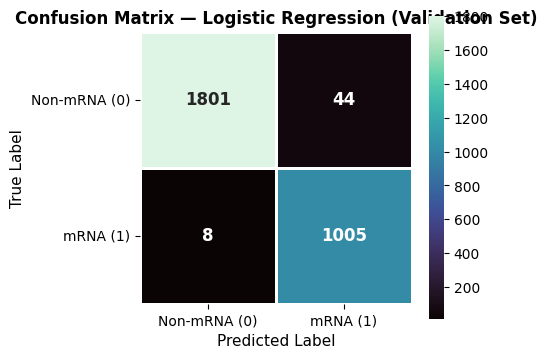

In [226]:
# Confusion matrix heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# compute confusion matrix
cm = confusion_matrix(y_val, val_pred, labels=[0, 1])

# create heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="mako",
    linewidths=1,
    cbar=True,
    square=True,
    annot_kws={"size": 12, "weight": "bold"}
)

plt.title("Confusion Matrix — Logistic Regression (Validation Set)", fontsize=12, weight="bold")
plt.xlabel("Predicted Label", fontsize=11)
plt.ylabel("True Label", fontsize=11)
plt.xticks([0.5, 1.5], ["Non-mRNA (0)", "mRNA (1)"])
plt.yticks([0.5, 1.5], ["Non-mRNA (0)", "mRNA (1)"], rotation=0)
plt.tight_layout()
plt.show()

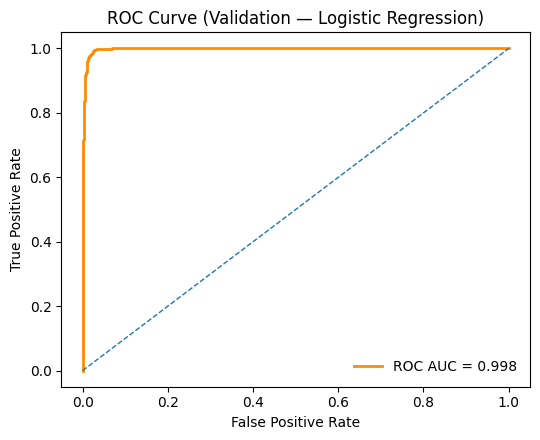

In [227]:
# ROC curve
fpr, tpr, _ = roc_curve(y_val, val_prob)
rocA = sk_auc(fpr, tpr)
plt.figure(figsize=(5.5, 4.5))
plt.plot(fpr, tpr, color="darkorange", linewidth=2, label=f"ROC AUC = {rocA:.3f}")
plt.plot([0,1], [0,1], "--", linewidth=1)
plt.title("ROC Curve (Validation — Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
plt.show()

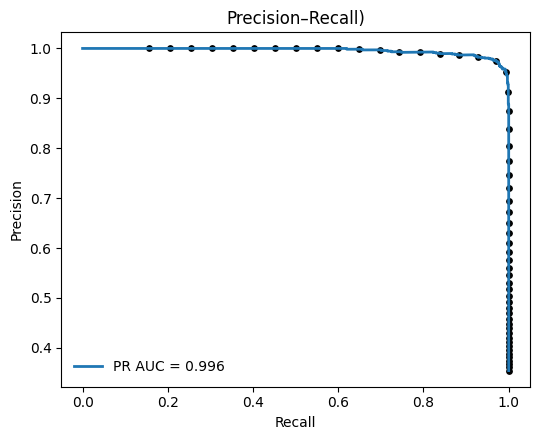

In [228]:
# Precision–Recall curve
prec, rec, _ = precision_recall_curve(y_val, val_prob)
prA = sk_auc(rec, prec)
plt.figure(figsize=(5.5, 4.5))
plt.plot(rec, prec, linewidth=2, label=f"PR AUC = {prA:.3f}")
plt.scatter(rec[::50], prec[::50], color="black", s=15)
plt.title("Precision–Recall)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(loc="lower left", frameon=False)
plt.tight_layout()
plt.show()

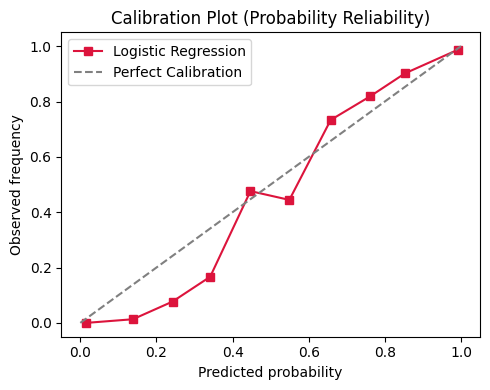

In [229]:
# Calibration curve
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_val, val_prob, n_bins=10)
plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, "s-", color="crimson", label="Logistic Regression")
plt.plot([0,1],[0,1],"--", color="gray", label="Perfect Calibration")
plt.title("Calibration Plot (Probability Reliability)")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.legend()
plt.tight_layout()
plt.show()

## Saving the trained model

In [230]:
import joblib
joblib.dump(lr_pipe, "LR_model.pkl")

['LR_model.pkl']

# ROC Curve Comparison

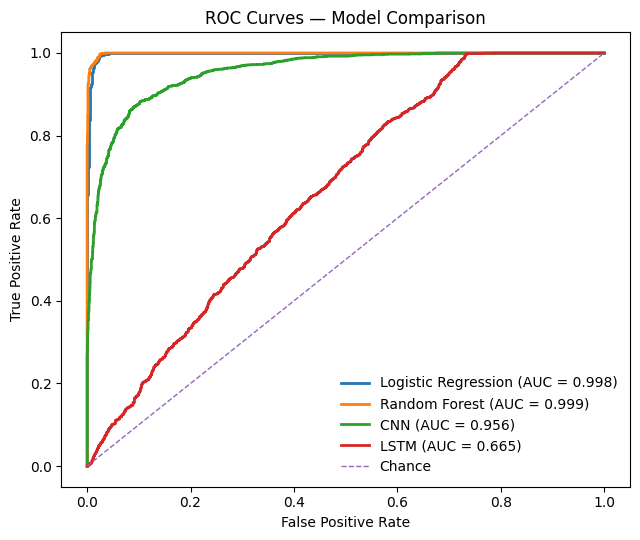

In [232]:
# Logistic Regression
lr_y_true  = y_val
lr_y_prob  = val_prob

# Random Forest
rf_y_true  = rf_y_val
rf_y_prob  = rf_val_prob

# CNN
cnn_y_true = cnn_y_test
cnn_y_prob = cnn_y_pred_probs

# LSTM
lstm_y_true = y_test
lstm_y_prob = y_pred_prob

models = [
    ("Logistic Regression", lr_y_true,  lr_y_prob),
    ("Random Forest", rf_y_true,  rf_y_prob),
    ("CNN", cnn_y_true, cnn_y_prob),
    ("LSTM", lstm_y_true, lstm_y_prob),
]

plt.figure(figsize=(6.5, 5.5))

for name, y_true, y_prob in models:
    if y_true is None or y_prob is None:
        continue
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    rocA = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC = {rocA:.3f})")

plt.plot([0, 1], [0, 1], "--", linewidth=1, label="Chance")
plt.title("ROC Curves — Model Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", frameon=False)
plt.tight_layout()
plt.show()

# Conclusion


**RF** achieved **best overall performance**.

**LR** achieved **comparable performance**.

**CNN** and **LSTM** **underperformed**:

*   **CNN** showed mild overfitting likely due to limited (~14k) samples versus model capacity
*   **LSTM** struggled with long-range dependencies given short sequences and moderate data, leading to poor generalisation